In [270]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-07-18T18:02:26.606105-04:00

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

Compiler    : MSC v.1937 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 16
Architecture: 64bit



In [336]:
# Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

import os

from func_utils import *

# Display and graph options

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Customize the font and title size
custom_params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.family": "Arial"
}
sns.set_context("notebook", rc=custom_params)

# Set a color palette
sns.set_palette("Set2") 

# Set global option to display numbers in plain format
pd.set_option('display.float_format', '{:.2f}'.format)

# Filter warnings and seeds
import warnings
import random

warnings.filterwarnings('ignore')
random.seed(1234)

In [291]:
# Data 

CustomerData = pd.read_excel('DATA/CustomersData.xlsx')
Discount_Coupon = pd.read_csv('DATA/Discount_Coupon.csv')
Marketing_Spend = pd.read_csv('DATA/Marketing_Spend.csv')
Online_Sales = pd.read_csv('DATA/Online_Sales.csv')
Tax_amount = pd.read_excel('DATA/Tax_amount.xlsx')

# Business Questions

### 1. Calculate Invoice amount or sale_amount or revenue for each transaction and item level 
$$ Invoice Value =[\frac{Quantity*Avg\_price}{(1-Dicount\_pct)}*(1+GST)]+Delivery\_Charges$$

In [292]:
# Including the GST information

data_tmp = pd.merge(Online_Sales, Tax_amount, how='left', on='Product_Category')
data_tmp.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,GST
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,0.10
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,0.10
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,0.10
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,0.18
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,0.18


In [294]:
# Including discount_pct information
## ajusting the month name
data_tmp['Transaction_Date2'] = pd.to_datetime(data_tmp['Transaction_Date'])
data_tmp['Month'] = data_tmp['Transaction_Date2'].dt.strftime('%b')

## Merging the tables
data_tmp = pd.merge(data_tmp, Discount_Coupon,how='left', on=['Month','Product_Category'])

In [295]:
# Creating a new column to ajust the discount
# I will apply the discount if, just if, the coupon_status == Used.

data_tmp['Discount_pct_ajus'] = data_tmp.apply(lambda x: x['Discount_pct'] if x['Coupon_Status'] == 'Used' else 0, axis=1)

In [296]:
data_tmp['Invoice'] = (data_tmp['Quantity'] * data_tmp['Avg_Price'] / (1 - data_tmp['Discount_pct_ajus']/100)*(1+data_tmp['GST']) + data_tmp['Delivery_Charges'])

In [297]:
data_tmp['Invoice'].describe()

count   52798.00
mean      117.12
std       198.97
min         4.86
25%        22.18
50%        51.48
75%       169.62
max     13803.51
Name: Invoice, dtype: float64

In [298]:
print(f'The total invoice amount is ${data_tmp["Invoice"].sum():,.2f}')

The total invoice amount is $6,183,896.12


In [1]:
### The invoice transation for each product

invoice_product = pd.DataFrame(data_tmp.groupby('Product_Category')['Invoice'].agg('sum').reset_index(name = 'total'))
invoice_product['prop'] = invoice_product['total']/invoice_product['total'].sum()*100
invoice_product.sort_values('total', ascending=False)

### Graph Sankey

data_sankey = data_tmp.groupby(['Product_Category','Product_Description'])['Invoice'].agg('sum').reset_index()
data_sankey.columns = ['source', 'target', 'value']


### Tabela Resumo
qtde_product_cat = data_sankey['source'].value_counts().reset_index(name = 'qtde_items')
qtde_product_cat.columns = ['source','qtde_items']

invoice_product = pd.merge(invoice_product, qtde_product_cat, how='left', left_on='Product_Category', right_on='source')
invoice_product['avg_product_cateory'] = invoice_product['total']/invoice_product['qtde_items']
invoice_product.sort_values('total', ascending=False)


NameError: name 'pd' is not defined

In [300]:
import plotly.graph_objects as go

# Extract unique labels
all_labels = list(set(data_sankey['source'].tolist() + data_sankey['target'].tolist()))

# Create a mapping from label to index
label_to_index = {label: index for index, label in enumerate(all_labels)}

# Map the source and target labels to indices
data_sankey['source_id'] = data_sankey['source'].apply(lambda x: label_to_index[x])
data_sankey['target_id'] = data_sankey['target'].apply(lambda x: label_to_index[x])

# Create the link and node data for the Sankey diagram
link = dict(source=data_sankey['source_id'], target=data_sankey['target_id'], value=data_sankey['value'])
node = dict(label=all_labels, pad=15, thickness=20, line=dict(color="black", width=0.5))

# Create the Sankey diagram
sankey_data = go.Sankey(link=link, node=node)

# Create the figure
fig = go.Figure(data=sankey_data)

# Show the figure
fig.show()

## 2. Perform Detailed exploratory analysis  

### 2.1. Understanding how many customers acquired every month  

In [301]:
data_tmp = pd.merge(data_tmp, CustomerData, how='left', on='CustomerID')

In [304]:
# Month

data_tmp['Transaction_Date'] = pd.to_datetime(data_tmp['Transaction_Date'])
data_tmp['month'] = data_tmp['Transaction_Date'].dt.month

# Group by Month to calculate required metrics
monthly_metrics = data_tmp.groupby('month').agg(
    distinct_clients = ('CustomerID', 'nunique'),
    total_transactions = ('Transaction_ID', 'nunique'),
    total_sales = ('Invoice', 'sum')
)

monthly_metrics['avg_trans_per_client'] = monthly_metrics['total_transactions']/monthly_metrics['distinct_clients']
monthly_metrics['avg_invoice_per_client'] = monthly_metrics['total_sales']/monthly_metrics['distinct_clients']

display(monthly_metrics)

,distinct_clients,total_transactions,total_sales,avg_trans_per_client,avg_invoice_per_client
month,,,,,
1,215,2102,523660.45,9.78,2435.63
2,109,1664,423216.27,15.27,3882.72
3,208,1991,504022.34,9.57,2423.18
4,224,1813,506979.77,8.09,2263.30
5,200,2034,412039.52,10.17,2060.20
6,259,1940,447846.75,7.49,1729.14
7,236,2080,478877.68,8.81,2029.14
8,300,2414,545112.93,8.05,1817.04
9,193,1932,503963.26,10.01,2611.21


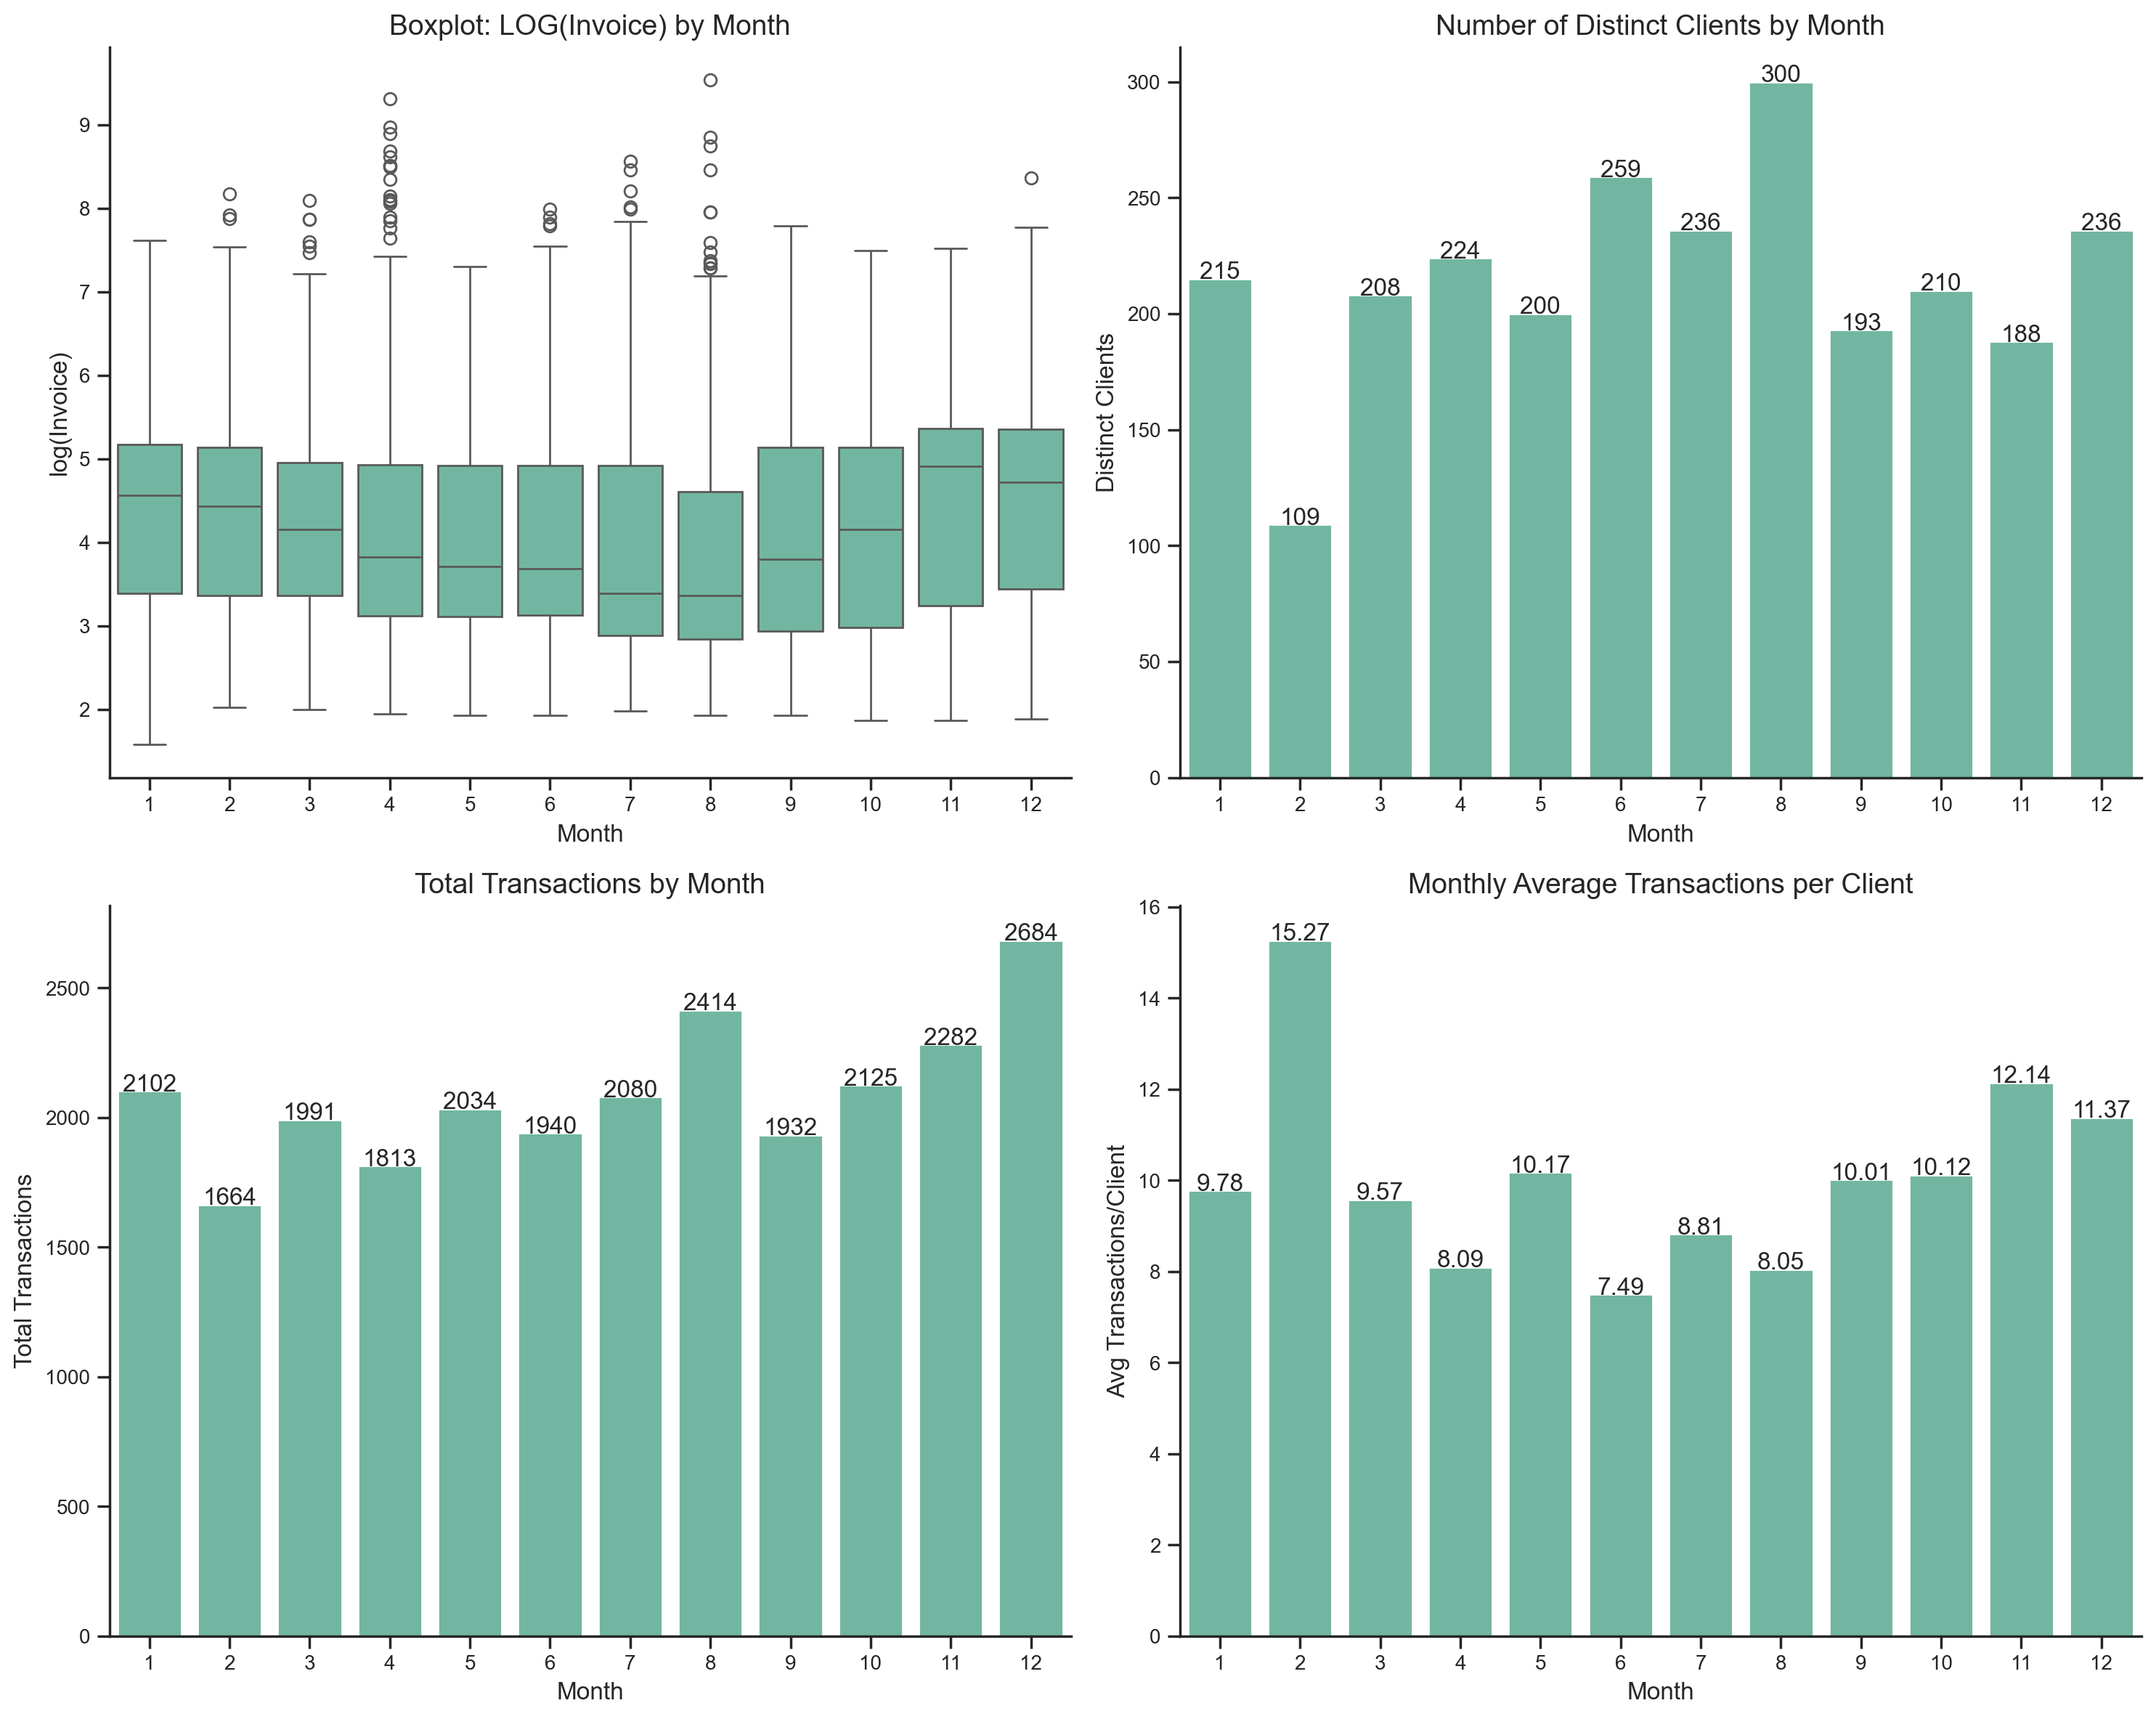

In [305]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Boxplot: Invoice by Month
g1 = sns.boxplot(x=data_tmp['month'], y=np.log(data_tmp['Invoice']), ax=axes[0, 0])
g1.set_title('Boxplot: LOG(Invoice) by Month')
g1.set_xlabel('Month')
g1.set_ylabel('log(Invoice)')

# Barplot: Number of Distinct Clients by Month
g2 = sns.barplot(x=monthly_metrics.index, y=monthly_metrics['distinct_clients'], ax=axes[0, 1])
g2.set_title('Number of Distinct Clients by Month')
g2.set_xlabel('Month')
g2.set_ylabel('Distinct Clients')
for index, value in enumerate(monthly_metrics['distinct_clients']):
    g2.text(index, value, f'{value:.0f}', ha='center')

# Barplot: Monthly Average Transactions per Client
g3 = sns.barplot(x=monthly_metrics.index, y=monthly_metrics['avg_trans_per_client'], ax=axes[1, 1])
g3.set_title('Monthly Average Transactions per Client')
g3.set_xlabel('Month')
g3.set_ylabel('Avg Transactions/Client')
for index, value in enumerate(monthly_metrics['avg_trans_per_client']):
    g3.text(index, value, f'{value:.2f}', ha='center')

# Barplot: Total Transactions by Month
g4 = sns.barplot(x=monthly_metrics.index, y=monthly_metrics['total_transactions'], ax=axes[1, 0])
g4.set_title('Total Transactions by Month')
g4.set_xlabel('Month')
g4.set_ylabel('Total Transactions')
for index, value in enumerate(monthly_metrics['total_transactions']):
    g4.text(index, value, f'{value:.0f}', ha='center')

plt.tight_layout()
plt.show()


### 2.2. Understand the retention of customers on month on month basis

To understand the retention of customers on a month-on-month basis, I will analyze the data to see how many customers from one monyh make repeat purchases in the following months.    
I'll create a matrix to show the number of customer retained from one month to the next and then calculate the retetion rate.

To calculate it, i will use the columns: `CustomerID` and `Transaction_Date`.

In [306]:
# Selecting the columns
retention_df = data_tmp[['CustomerID', 'Transaction_Date', 'month']]
retention_df['Transaction_Date'] = pd.to_datetime(retention_df['Transaction_Date']).dt.to_period('M')

# Removing the duplicated columns (if a client bought more than once, it is irrelevant for this analysis)
retention_df  = retention_df.drop_duplicates()

retention_df['first_purchase'] = retention_df.groupby('CustomerID')['Transaction_Date'].transform('max')

# Calculating the difference in months between the current transaction and the first purchase
retention_df['diff_months'] = abs(retention_df['first_purchase'].dt.month - retention_df['Transaction_Date'].dt.month)

retention_df

,CustomerID,Transaction_Date,month,first_purchase,diff_months
0,17850,2019-01,1,2019-01,0
9,13047,2019-01,1,2019-12,11
26,12583,2019-01,1,2019-08,7
46,13748,2019-01,1,2019-01,0
65,15100,2019-01,1,2019-08,7
...,...,...,...,...,...
52851,14438,2019-12,12,2019-12,0
52890,12956,2019-12,12,2019-12,0
52909,15781,2019-12,12,2019-12,0
52914,14410,2019-12,12,2019-12,0


In [307]:
cohort_counts = retention_df.groupby(['Transaction_Date', 'diff_months', 'month'])['CustomerID'].nunique()

In [308]:
cohort_counts = retention_df.groupby(['Transaction_Date','diff_months','month'])['CustomerID'].nunique()
cohort_counts_df = cohort_counts.to_frame().rename(columns={'CustomerID':'users'}) \
                                .sort_values(by=['month'])

cohort_counts_df['retention_rate'] = cohort_counts_df['users'] / cohort_counts_df.groupby(["month"])["users"].transform("max")


cohorts_pivot = cohort_counts_df.pivot_table(index='Transaction_Date', columns = 'diff_months', values = 'retention_rate')


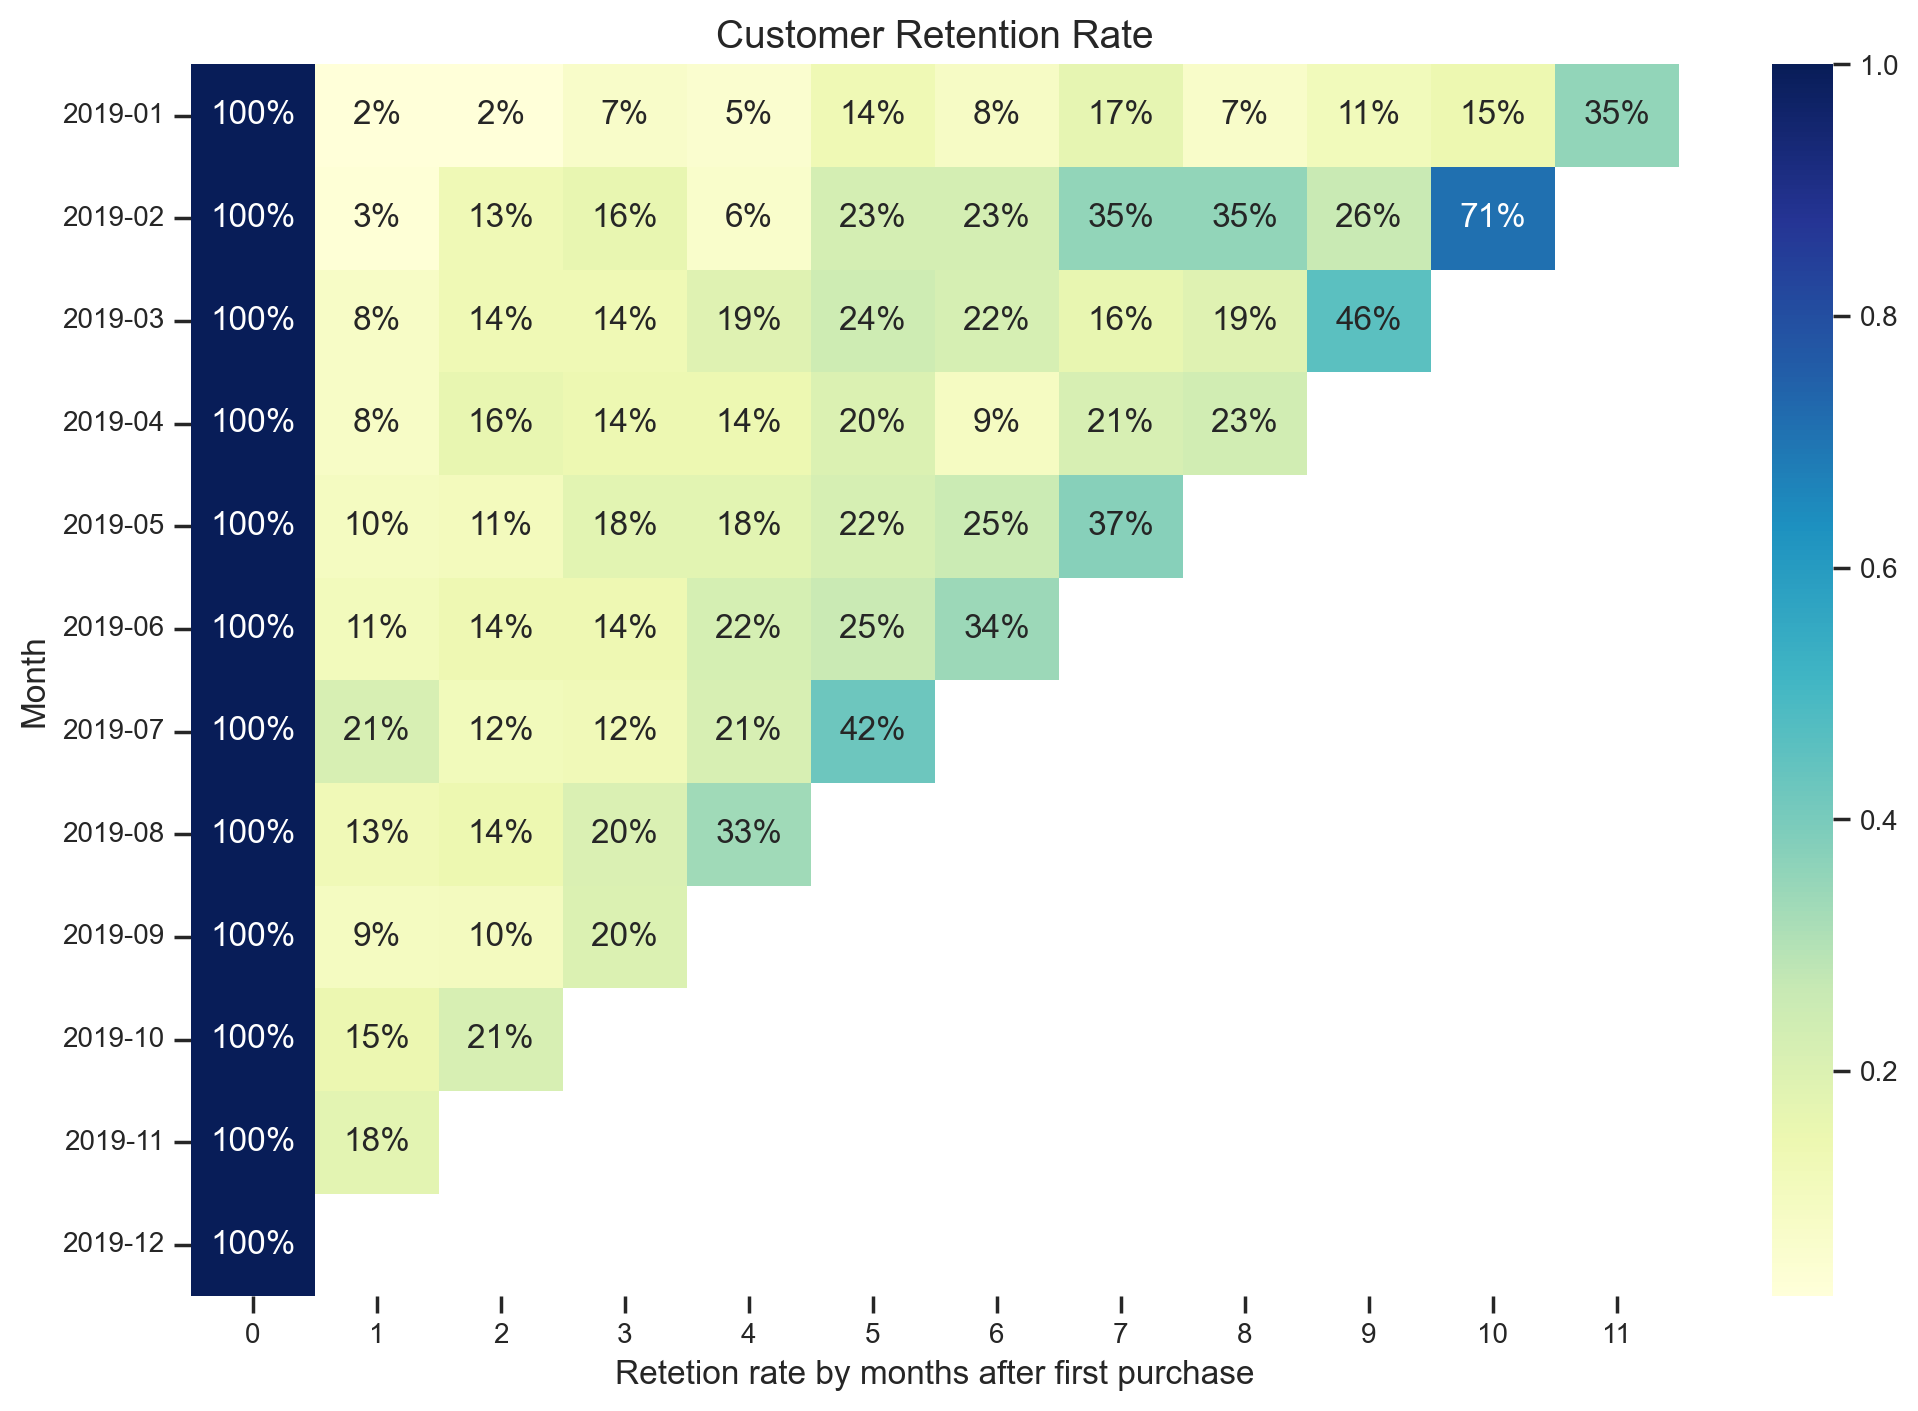

In [309]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(cohorts_pivot, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title('Customer Retention Rate')
plt.ylabel('Month')
plt.xlabel('Retetion rate by months after first purchase')
plt.yticks(rotation=0)
plt.show()


### 2.3. How the revenues from existing/new customers on month on month basis

To analyze the revenues from existing and new customers on a month-on-month bases, I will follow these steps:
1. Identify wheter each transaction is from a new or existing customer.
2. Calculate the revenues for each month, segregating new and existing customers.
3. Aggregate the revenues on a month-by-month basis.


In [310]:
# Columns
retention_df = data_tmp[['CustomerID', 'Transaction_Date', 'month', 'Invoice']]

# Converting 'Transation_Date' to datetime and formatting it to year_month
retention_df['Transaction_Date'] = pd.to_datetime(retention_df['Transaction_Date']).dt.to_period('M')

# Aggruping the Invoive values per customer and per month
retention_df = retention_df.groupby(['CustomerID', 'Transaction_Date', 'month'])['Invoice'].agg('sum').reset_index(name='invoice_total')

# Removing duplicated
retention_df = retention_df.drop_duplicates()

# Adding a column with the first purchase for each customer
retention_df['first_purchase'] = retention_df.groupby('CustomerID')['Transaction_Date'].transform('min')

# Labeling the customers - new and existing
retention_df['customer_type'] = retention_df.apply(lambda row: 'New' if row['Transaction_Date'] == row['first_purchase'] else 'Existing', axis = 1)

# Calculating the revenues for each month and customer type
monthly_revenue = retention_df.groupby(['Transaction_Date', 'customer_type'])['invoice_total'].sum().reset_index()

# Pivoting the table to get the revenue matrix for new and existing customers
monthly_revenue_pivot = monthly_revenue.pivot_table(index='Transaction_Date', columns='customer_type', values='invoice_total', fill_value=0)
monthly_revenue_pivot['prop_new'] = monthly_revenue_pivot['New']/monthly_revenue_pivot.sum(axis=1) * 100

monthly_revenue_pivot

customer_type,Existing,New,prop_new
Transaction_Date,,,
2019-01,0.00,523660.45,100.00
2019-02,53859.80,369356.47,87.27
2019-03,81572.76,422449.57,83.82
2019-04,207883.41,299096.36,59.00
2019-05,148010.51,264029.00,64.08
2019-06,183346.56,264500.19,59.06
2019-07,288376.12,190501.56,39.78
2019-08,284662.73,260450.20,47.78
2019-09,297115.47,206847.79,41.04


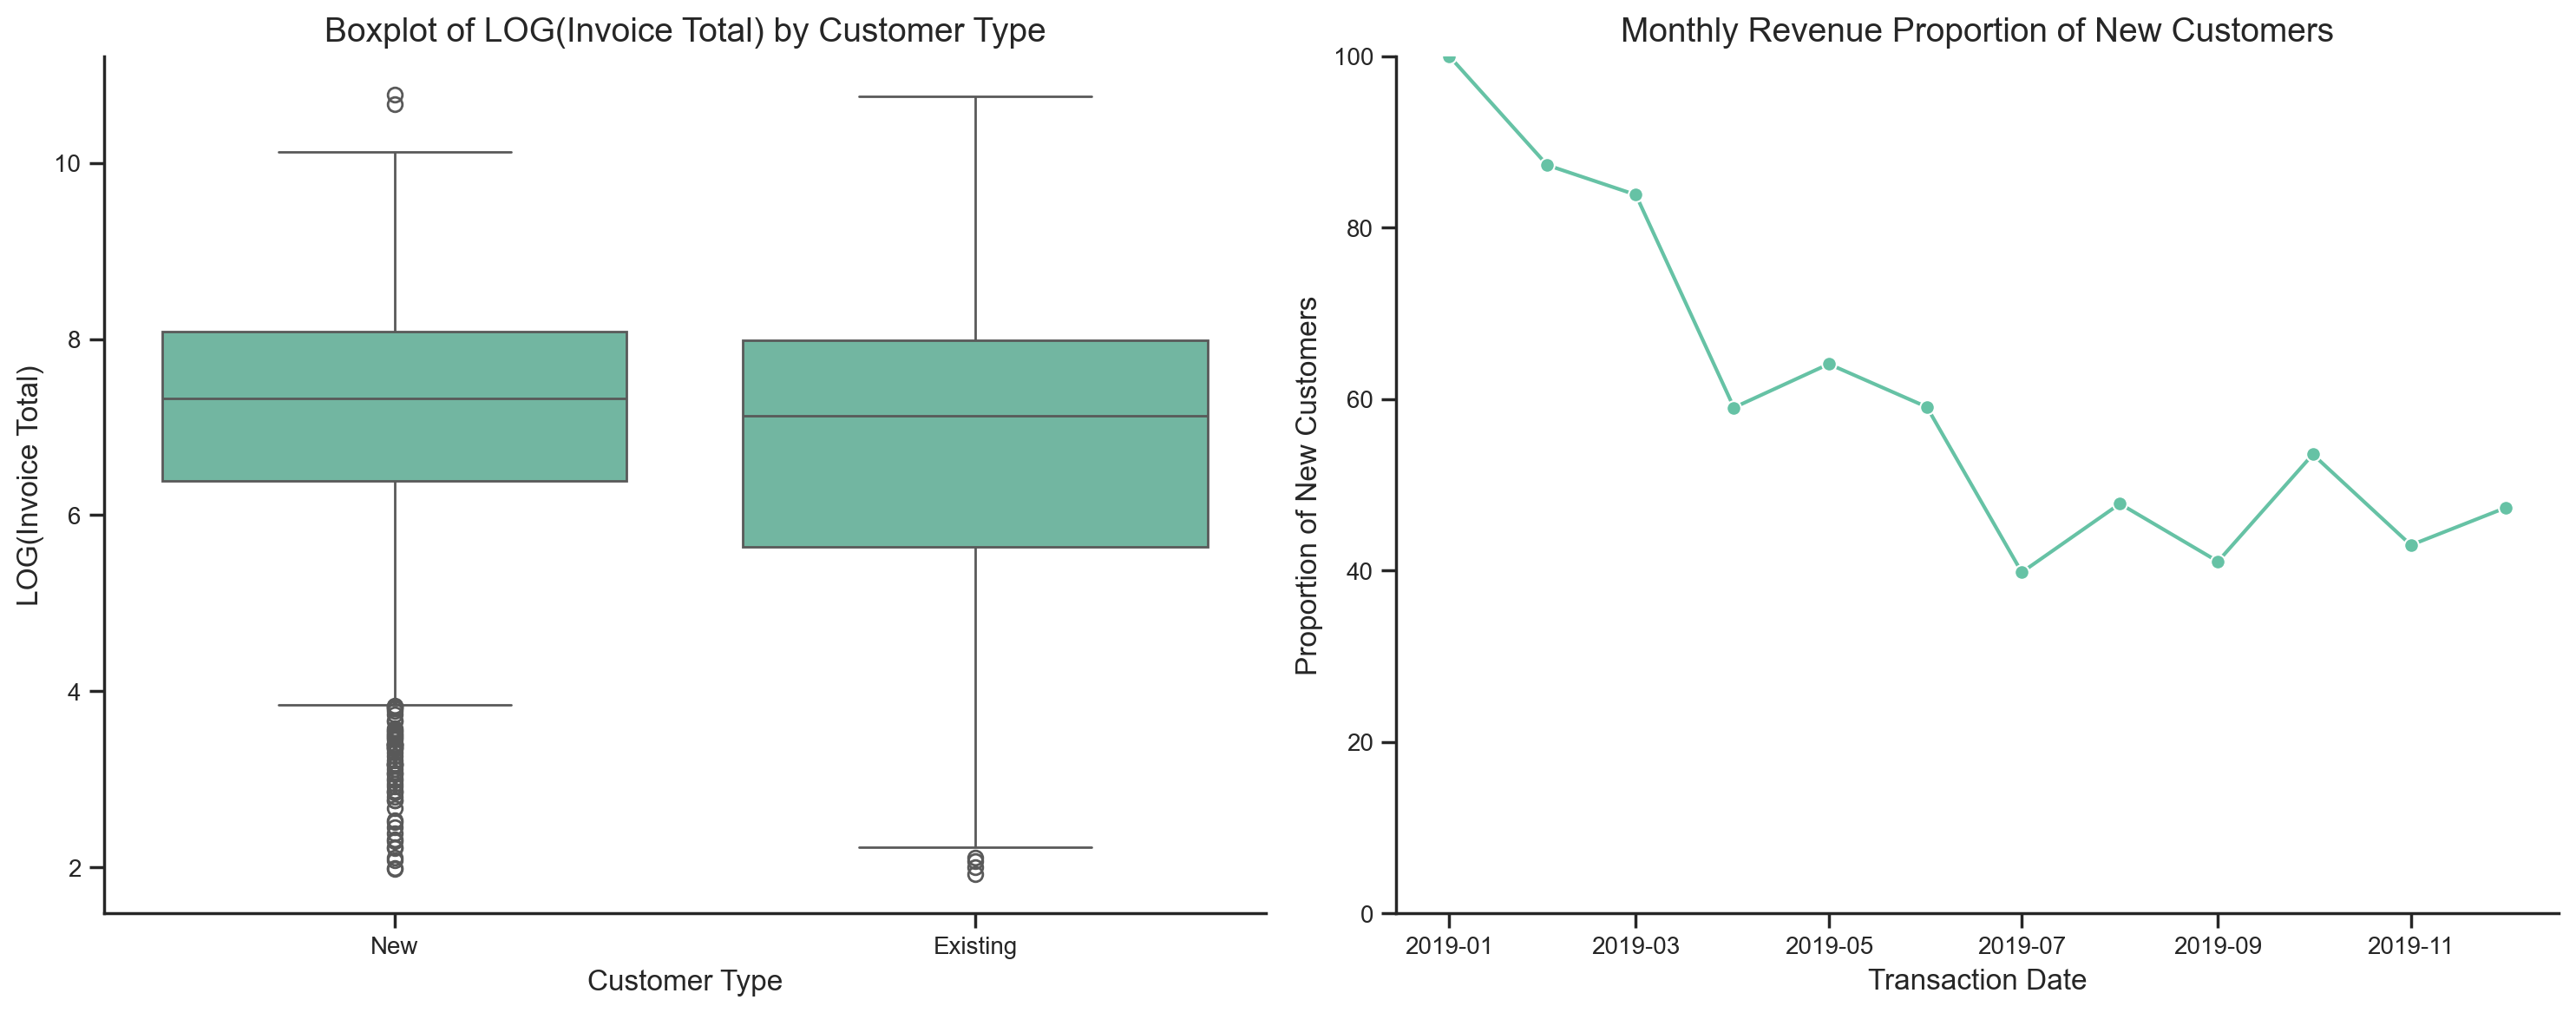

In [311]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

retention_df['log_invoice_total'] = np.log(retention_df['invoice_total'])


# Gráfico de caixa (Boxplot)
g1 = sns.boxplot(x='customer_type', y=('log_invoice_total'), data=retention_df, ax=axes[0])
g1.set_title('Boxplot of LOG(Invoice Total) by Customer Type')
g1.set_xlabel('Customer Type')
g1.set_ylabel('LOG(Invoice Total)')

teste = monthly_revenue_pivot.copy()
teset = teste.reset_index()

# Gráfico de linha (Line plot)
g2 = sns.lineplot(x=teste.index.to_timestamp(), y='prop_new', data=teste, ax=axes[1], marker='o')
g2.set_title('Monthly Revenue Proportion of New Customers')
g2.set_xlabel('Transaction Date')
g2.set_ylabel('Proportion of New Customers')
g2.set_ylim(0,100)

plt.tight_layout()
plt.show()

In [312]:
# Testing if there is different between the values of new and existing invoices
grouped_describe = retention_df.groupby('customer_type')['invoice_total'].describe()
display(grouped_describe)
display(test_means_equality(retention_df, 'invoice_total', 'customer_type'))

,count,mean,std,min,25%,50%,75%,max
customer_type,,,,,,,,
Existing,1110.00,2260.42,3377.81,6.80,280.86,1242.73,2950.04,46976.05
New,1468.00,2503.29,3210.40,7.22,594.19,1513.08,3253.07,47685.71


{'p-value': 9.410872654706354e-06,
 'statistically_significant': True,
 'message': 'There is a statistically significant difference between the groups.'}

- According the test, there is a statistically significant difference between the news and the existing customers.
- Analysing the proportion of Invoice(News) comparing with the Invoice(Existent), the graph shows that the proportion tends to be half to half.

### 2.4. How the discounts playing role in the revenues?  

In [313]:
invoice_discounts = data_tmp[['Invoice', 'Discount_pct_ajus', 'month']]
invoice_discounts.groupby(['month','Discount_pct_ajus'])['Invoice'].describe()

count   mean    std  min   25%    50%    75%  \
month Discount_pct_ajus                                                  
1     0.00              2680.00 128.12 139.83 4.86 29.05  96.15 175.58   
      10.00             1370.00 131.60 135.68 5.68 29.48 106.11 194.37   
2     0.00              2186.00 124.09 169.77 7.59 27.49  81.33 170.40   
      20.00             1084.00 140.18 172.33 8.15 31.56  88.64 190.98   
3     0.00              2870.00 105.34 155.97 7.37 26.55  58.40 137.40   
      30.00             1458.00 138.33 159.19 8.07 35.14  77.27 193.50   
4     0.00              2720.00 119.61 348.24 7.09 22.18  45.57 136.90   
      10.00             1414.00 128.45 378.65 6.97 24.32  47.54 151.44   
5     0.00              3080.00  86.41 120.74 6.87 21.74  38.86 136.13   
      20.00             1475.00  98.91 119.86 7.36 25.60  42.80 149.57   
6     0.00              2774.00  95.15 138.38 6.87 21.95  38.08 136.90   
      30.00             1408.00 130.60 197.28 7.24 27.96  43.43 193.00   
7     0.00              3494.00  89.85 184.88 7.31 17.33  29.03 136.90   
      10.00             1743.00  94.62 179.78 7.21 18.59  32.21 151.44   
8     0.00              4057.00  81.38 178.03 6.87 16.76  26.74  95.68   
      20.00             2078.00 103.44 371.03 7.09 17.80  31.06 112.32   
9     0.00              2798.00  99.77 140.66 6.87 17.33  39.03 136.90   
      30.00             1487.00 151.18 214.64 7.89 22.51  56.57 215.98   
10    0.00              2754.00 120.50 148.35 6.44 18.97  60.15 169.90   
      10.00             1406.00 128.05 152.61 6.49 20.68  68.60 188.11   
11    0.00              2597.00 146.80 158.58 6.44 24.42 110.45 181.12   
      20.00             1363.00 186.37 196.52 6.55 28.41 168.10 265.88   
12    0.00              3010.00 137.62 151.73 6.56 27.66 112.46 173.57   
      30.00             1492.00 185.51 222.32 6.80 36.72 139.52 245.17   

                             max  
month Discount_pct_ajus           
1     0.00               2032.98  
      10.00              1277.18  
2     0.00               3539.42  
      20.00              2749.62  
3     0.00               3272.26  
      30.00              1894.03  
4     0.00               7876.25  
      10.00             11084.00  
5     0.00               1480.41  
      20.00               919.52  
6     0.00               2950.10  
      30.00              2673.74  
7     0.00               4727.85  
      10.00              5252.50  
8     0.00               6301.80  
      20.00             13803.51  
9     0.00               1710.10  
      30.00              2406.88  
10    0.00               1798.29  
      10.00              1408.39  
11    0.00               1810.25  
      20.00              1843.85  
12    0.00               2377.32  
      30.00              4269.42

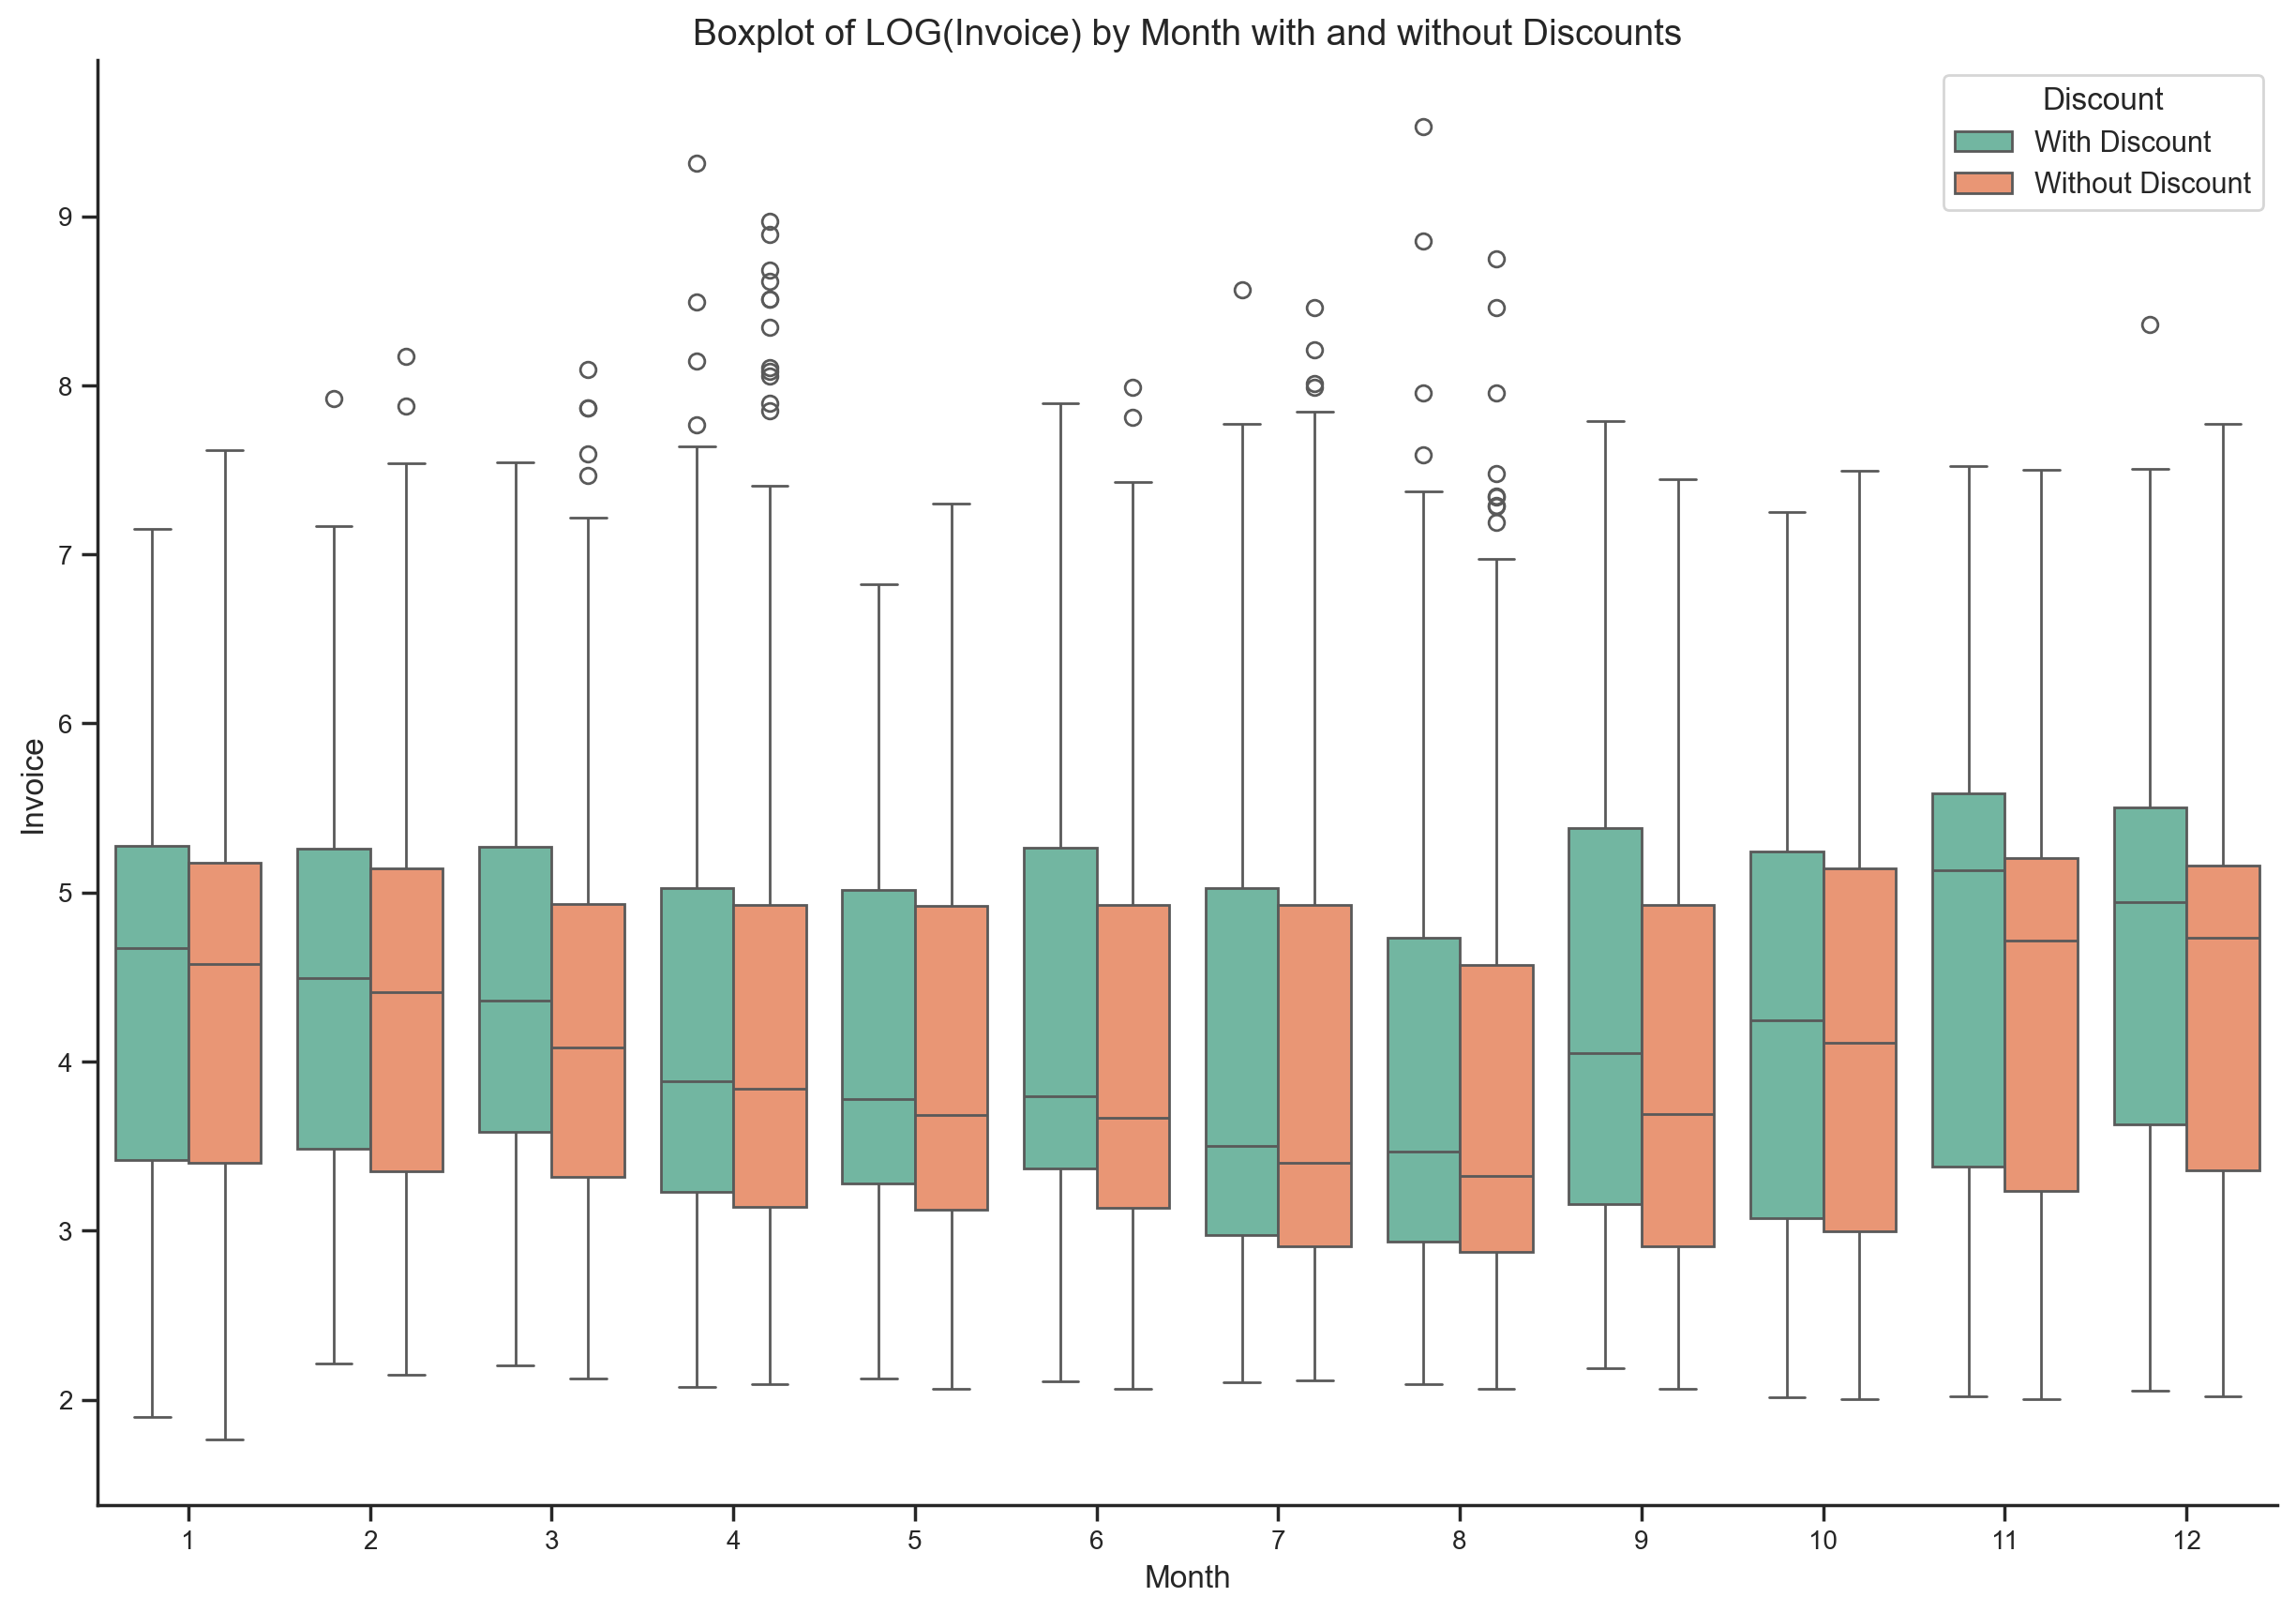

In [314]:
invoice_discounts['Discount'] = invoice_discounts['Discount_pct_ajus'].apply(lambda x: 'With Discount' if x > 0 else 'Without Discount')


invoice_discounts['Log_Invoice'] = np.log(invoice_discounts['Invoice'] + 1) 

# Criar o boxplot mês a mês
plt.figure(figsize=(15, 10))
sns.boxplot(x='month', y='Log_Invoice', hue='Discount', data=invoice_discounts)
plt.title('Boxplot of LOG(Invoice) by Month with and without Discounts')
plt.xlabel('Month')
plt.ylabel('Invoice')
plt.legend(title='Discount')
plt.show()

In [315]:

# Create a table with ANOVA results for each month
anova_results = []
for month in invoice_discounts['month'].unique():
    test_used, f_stat, p_value = perform_test(month, invoice_discounts)
    if test_used is not None and f_stat is not None and p_value is not None:
        anova_results.append({'Month': month, 'Test Used': test_used, 'F-statistic': f_stat, 'P-value': p_value})

anova_results_df = pd.DataFrame(anova_results)
display(anova_results_df)

,Month,Test Used,F-statistic,P-value
0,1,Mann-Whitney,1897394.00,0.08
1,2,Mann-Whitney,1251780.50,0.01
2,3,Mann-Whitney,2424475.00,0.00
3,4,Mann-Whitney,2023787.00,0.01
4,5,Mann-Whitney,2469326.00,0.00
5,6,Mann-Whitney,2217179.50,0.00
6,7,Mann-Whitney,3219890.50,0.00
7,8,Mann-Whitney,4477821.00,0.00
8,9,Mann-Whitney,2409860.50,0.00
9,10,Mann-Whitney,2009468.50,0.05


- The boxplot and the test of equality of means show that there are significant differences between invoices with discounts and those without discounts, including for each month.

### 2.5. Analyse KPI’s like Revenue, number of orders, average order value, number of  customers (existing/new), quantity, by category, by month, by week, by day etc…

For this question, I am assuming that it has been answered in the other questions and in the EDA analysis.

### 2.6. Understand the trends/seasonality of sales by category, location, month etc…  

In [316]:
# Category

invoice_categories = data_tmp[['Transaction_Date', 'Invoice','Product_Category', 'month']]
invoice_categories = invoice_categories.groupby(['Product_Category', 'month'])['Invoice'].agg(sum).reset_index()
print(f' There are {invoice_categories['Product_Category'].nunique()} product categories.')

KeyError: "['Product_Category_x'] not in index"

In [3]:
# I added another visual in EDA

# Calculate the total invoice for each category
category_totals = invoice_categories.groupby('Product_Category')['Invoice'].sum().sort_values(ascending=False)

# Order the categories
ordered_categories = category_totals.index.tolist()

# Set up the subplot grid
n_categories = len(ordered_categories)
n_cols = 4  # Number of columns in the grid
n_rows = (n_categories // n_cols) + (n_categories % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each category in the ordered list and create a plot
for i, category in enumerate(ordered_categories):
    ax = axes[i]
    
    # Plot all categories in grey
    sns.lineplot(data=invoice_categories, x='month', y='Invoice', hue='Product_Category', 
                 palette=['#d3d3d3'], ax=ax, legend=False)

    # Highlight the current category
    sns.lineplot(data=invoice_categories[invoice_categories['Product_Category'] == category], 
                 x='month', y='Invoice', hue='Product_Category', palette=['#1f77b4'], ax=ax, legend=False, marker = 'o')
    
    # Set titles and labels
    ax.set_title(category)
    ax.set_xlabel('Month')
    ax.set_ylabel('Invoice Amount')

# Remove unused axes if the number of categories is not a perfect multiple of the grid size
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


NameError: name 'invoice_categories' is not defined

In [318]:
### Location

invoice_location = data_tmp[['Invoice', 'Location', 'month']]
invoice_location_total = data_tmp.groupby(['Location', 'month'])['Invoice'].agg('sum').reset_index()
print(f"There are {invoice_location_total['Location'].nunique()} locations.")

There are 5 locations.


In [319]:
total_invoice_location = invoice_location_total.groupby('Location')['Invoice'].agg('sum').reset_index(name = 'value')
total_invoice_location['prop'] = total_invoice_location['value']/total_invoice_location['value'].sum()*100
total_invoice_location.sort_values('prop', ascending=False)

,Location,value,prop
1,Chicago,2156537.46,34.87
0,California,1905286.39,30.81
3,New York,1250826.01,20.23
2,New Jersey,537299.27,8.69
4,Washington DC,333946.99,5.40


- Chicago represents 35% of purchases. The top 3 represents more than 85% of the sales.

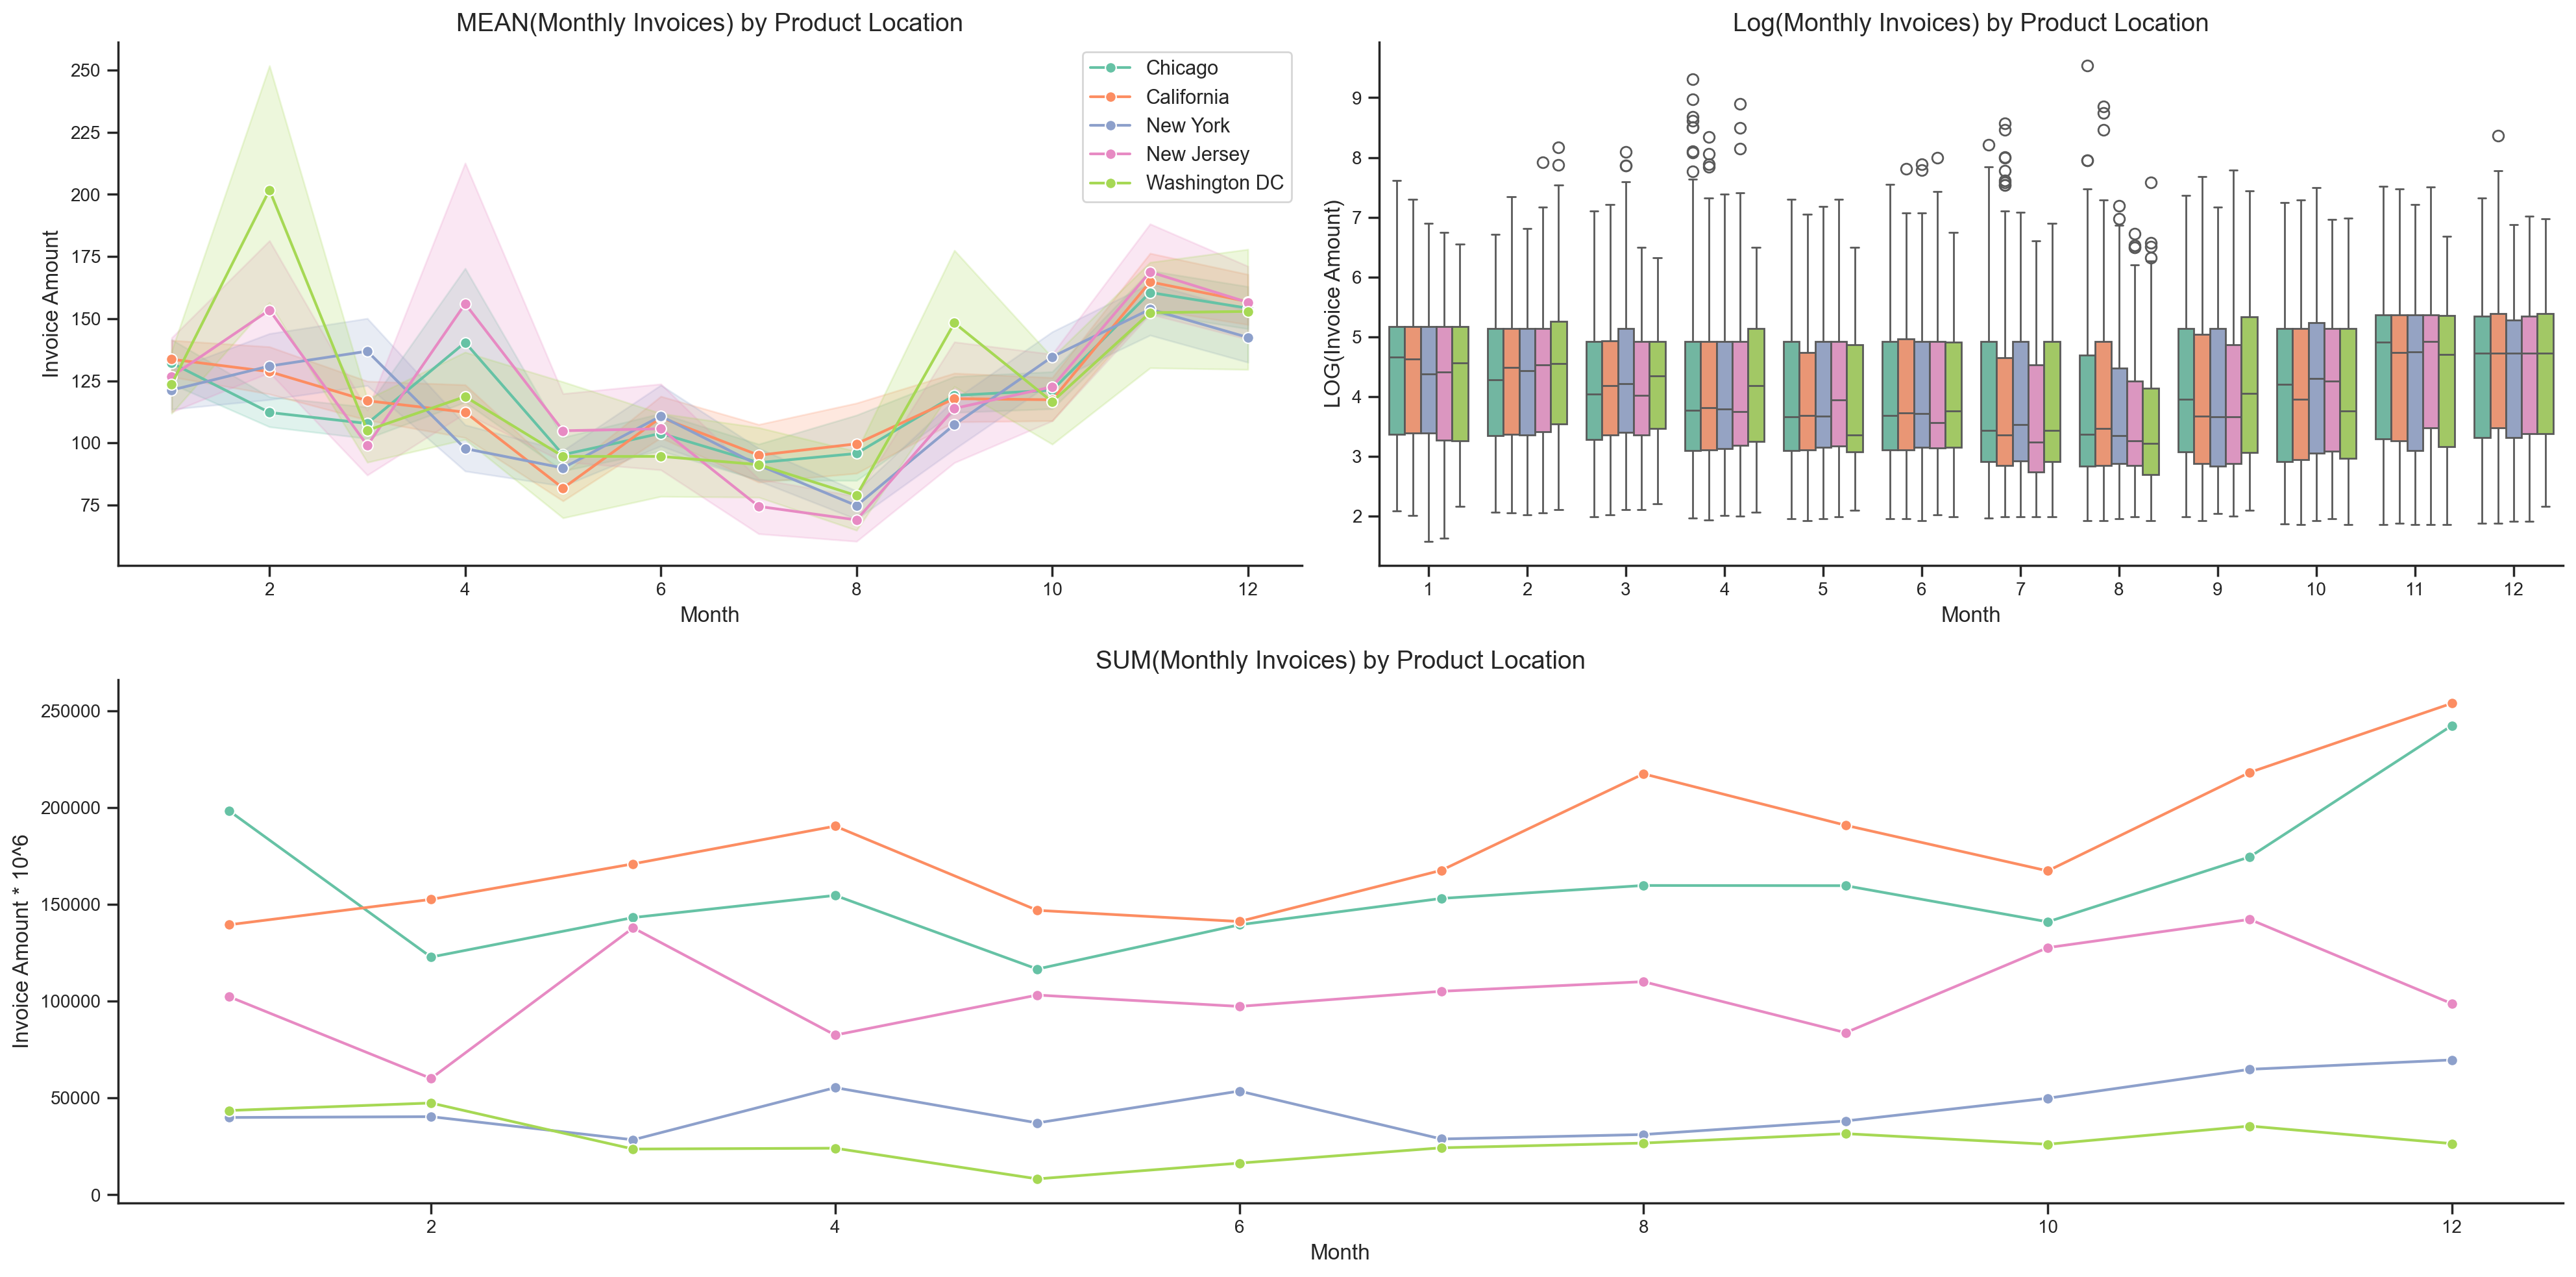

In [320]:

# Using log to invoice, I tried the original data and the viz wasn't good.

invoice_location['log_invoice'] = np.log(invoice_location['Invoice'])

# Create a grid with 2 rows and 2 columns using GridSpec
fig = plt.figure(figsize=(20, 10))
grid = plt.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# Plot 1: Line plot for SUM(Monthly Invoices) by Product Location
ax1 = fig.add_subplot(grid[0, 0])
sns.lineplot(data=invoice_location, x='month', y='Invoice', hue='Location', marker='o', ax=ax1)
ax1.set_title('MEAN(Monthly Invoices) by Product Location')
ax1.set_xlabel('Month')
ax1.set_ylabel('Invoice Amount')
ax1.legend()

# Plot 2: Boxplot for Log(Monthly Invoices) by Product Location
ax2 = fig.add_subplot(grid[0, 1])
sns.boxplot(data=invoice_location, x='month', y='log_invoice', hue='Location', ax=ax2, legend=False)
ax2.set_title('Log(Monthly Invoices) by Product Location')
ax2.set_xlabel('Month')
ax2.set_ylabel('LOG(Invoice Amount)')

# Plot 3: Line plot for Monthly Invoices by Product Location spanning the entire second row
ax3 = fig.add_subplot(grid[1, :])
sns.lineplot(data=invoice_location_total, x='month', y='Invoice', hue='Location', marker='o', ax=ax3, legend=False)
ax3.set_title('SUM(Monthly Invoices) by Product Location')
ax3.set_xlabel('Month')
ax3.set_ylabel('Invoice Amount * 10^6')

# Adjust layout to make room for the legend and ensure plots are not overlapping
plt.tight_layout()


plt.show()



### 2.7. How number order varies and sales with different days?  

In [321]:
# Orders

orders_day = data_tmp[['Transaction_ID', 'Transaction_Date', 'Invoice', 'CustomerID']]
orders_day['Transaction_Date'] = pd.to_datetime(orders_day['Transaction_Date'])
orders_day['name_day'] = orders_day['Transaction_Date'].dt.day_name()

# Groups the orders and ID to sum the amount considering these two variables
orders_day_ID_tmp = orders_day.groupby(['Transaction_ID', 'Transaction_Date', 'name_day', 'CustomerID' ]).agg(
    unique_transaction = ('Transaction_ID', 'nunique'),
    invoice_total = ('Invoice', 'sum')
).reset_index()

# Groups considering just the variable days
orders_day_DATE_tmp = orders_day.groupby(['Transaction_Date', 'name_day']).agg(
    unique_transaction = ('Transaction_ID', 'nunique'),
    invoice_total = ('Invoice', 'sum')
).reset_index()

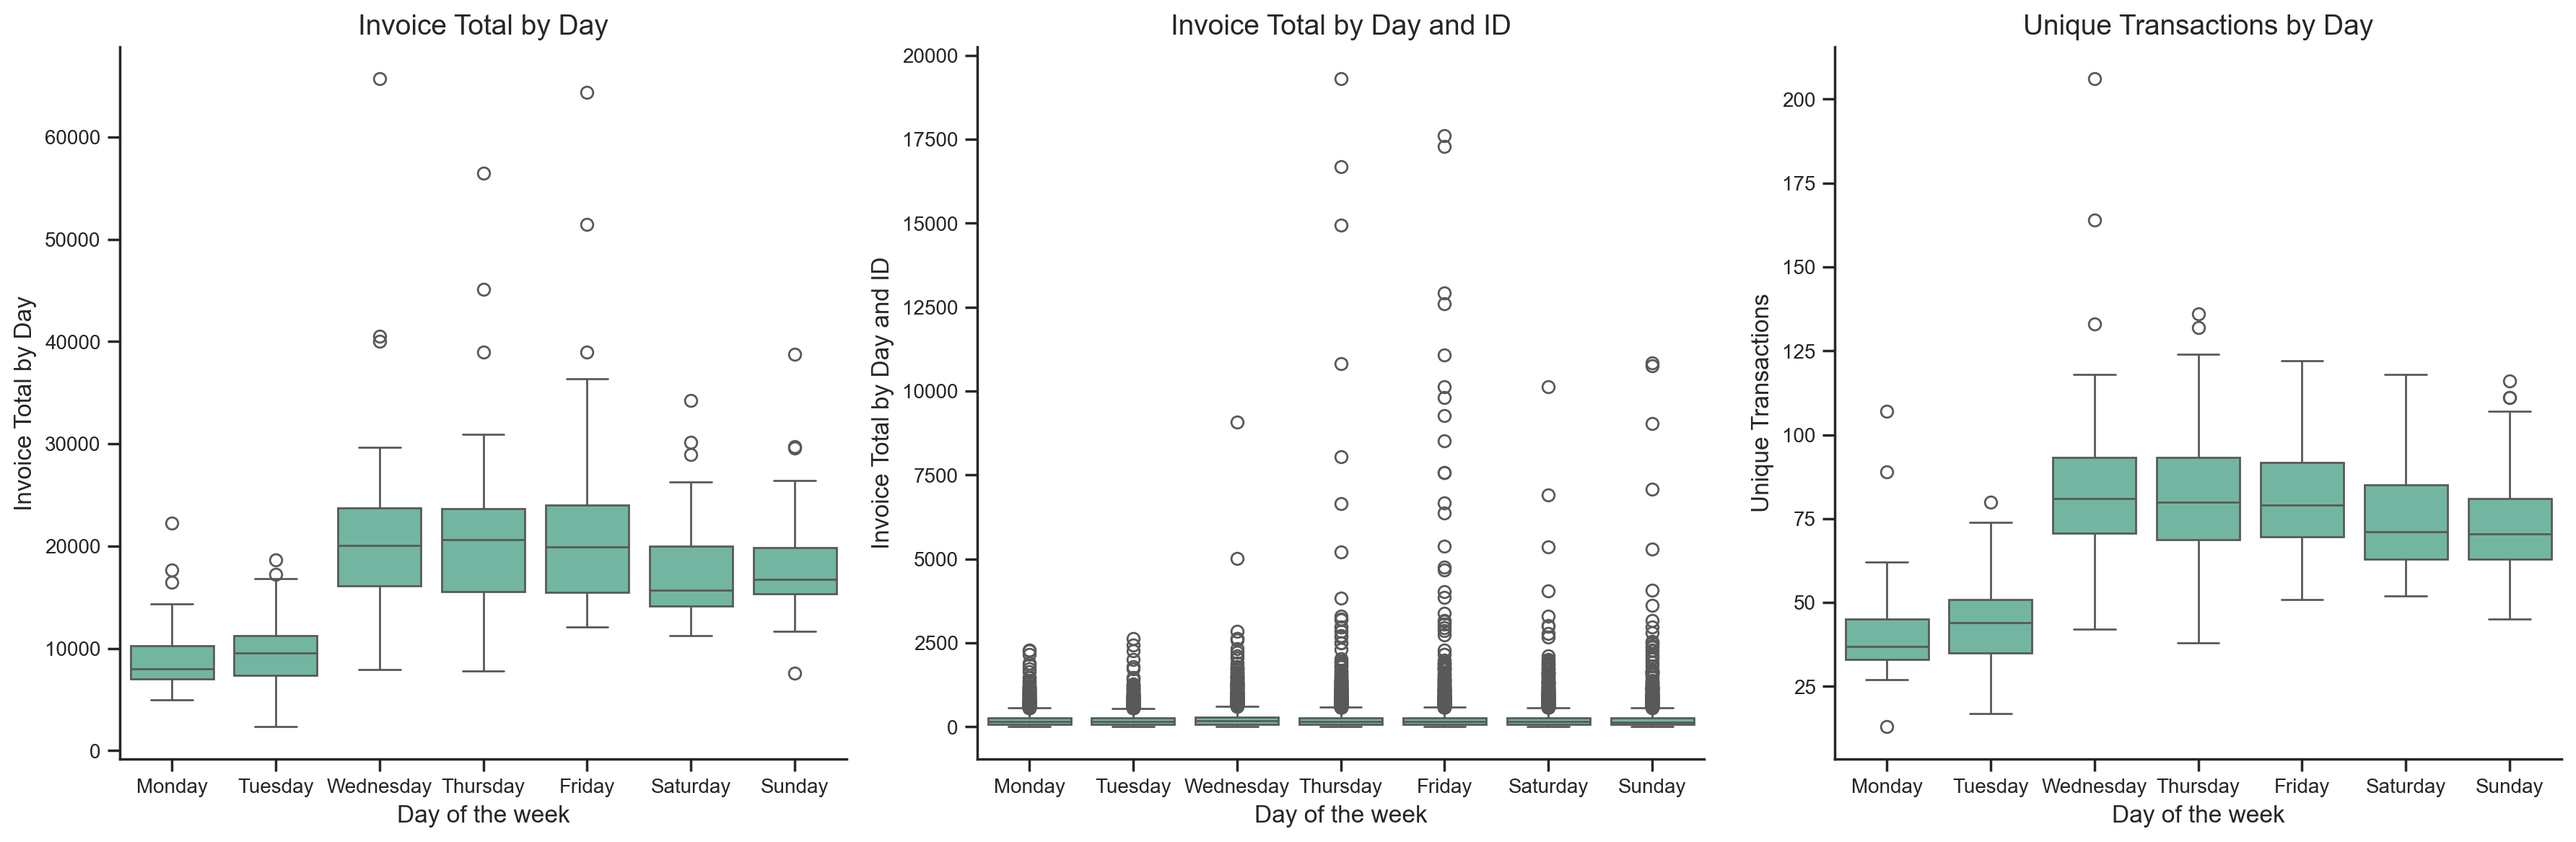

In [322]:
# Specify the order of the days of the week
order_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1,3,figsize=(18,6))

# First boxplot - Invoice total by day
sns.boxplot(ax=axes[0], x = 'name_day', y='invoice_total', data=orders_day_DATE_tmp, order=order_day)
axes[0].set_title('Invoice Total by Day')
axes[0].set_xlabel('Day of the week')
axes[0].set_ylabel('Invoice Total by Day')


# Second boxplot - Invoice total by day and ID
sns.boxplot(ax=axes[1], x = 'name_day', y='invoice_total', data=orders_day_ID_tmp, order=order_day)
axes[1].set_title('Invoice Total by Day and ID')
axes[1].set_xlabel('Day of the week')
axes[1].set_ylabel('Invoice Total by Day and ID')

# Second boxplot - Invoice total by day and ID
sns.boxplot(ax=axes[2], x = 'name_day', y='unique_transaction', data=orders_day_DATE_tmp, order=order_day)
axes[2].set_title('Unique Transactions by Day')
axes[2].set_xlabel('Day of the week')
axes[2].set_ylabel('Unique Transactions')

plt.tight_layout()
plt.show()

- For var invoice, both plots (fisrt and second) show similar distributions across the days of the week.
- There are significant outliers in both plots two first plots, with some invoices being substantially higher than the median, especially in the left plot.
- Analyzing the number of transactions by day, Monday and Tuesday are the days with the least sales. The days Wednesday through Friday show higher median values, and on the weekend, the median decreases slightly. It could be interesting to investigate if these "best" days are linked to specific events or promotions.

In [326]:
# Just out of curiosity, I will look at some outliers (this is not part of the question)

# # I will set up the value, but an alternative is to use the boundary limit for outliers.
Q3 = np.percentile(orders_day_ID_tmp['invoice_total'], 75)
Q1 = np.percentile(orders_day_ID_tmp['invoice_total'], 25)

outlier_test = Q3 + 1.5 * (Q3-Q1)
outlier_test


# Rule 1: Transaction with invoice higher than 50.000
orders_invoice_50000 = orders_day_ID_tmp[orders_day_ID_tmp['invoice_total'] > 5000].sort_values('CustomerID')

# Rule 2: Customers have more than one purchase higher than 50k.
duplicated_customers = orders_invoice_50000[orders_invoice_50000.duplicated('CustomerID', keep = False)]
duplicated_customers


,Transaction_ID,Transaction_Date,name_day,CustomerID,unique_transaction,invoice_total
6294,24860,2019-04-05,Friday,12748,1,11084.00
7772,26533,2019-04-27,Saturday,12748,1,10124.96
7807,26573,2019-04-27,Saturday,12748,1,5355.95
24387,45888,2019-12-06,Friday,14606,1,8512.10
24386,45887,2019-12-06,Friday,14606,1,6376.69
7155,25833,2019-04-18,Thursday,14667,1,10807.34
7159,25836,2019-04-18,Thursday,14667,1,6643.04
7153,25832,2019-04-18,Thursday,15311,1,14945.32
6298,24863,2019-04-05,Friday,15311,1,9258.19
6295,24860,2019-04-05,Friday,15311,1,12602.96


- CustomerID 12748:
    - This customer made substantial purchases, particularly on 2019-04-27.
- CustomerID 14606:
    - Has two transactions on the same day, 2019-12-06 (Friday).
    - These totals indicate substantial purchases on the same day, possibly splitting a large purchase into two transactions.
- CustomerID 14667:
    - Also appears twice on the same day, 2019-04-18 (Thursday).
- CustomerID 15311:
    - Multiple transactions on different dates: 2019-04-05 and 2019-04-18.
    - High-value transactions across different days, with the highest on 2019-04-18.
- CustomerID 15311:
    - Shows high-value transactions spread across month 4.

- Key Points:
    - Several customers have multiple high-value transactions, suggesting they are likely significant clients or businesses.
    - Transactions are spread across various days of the week, with no single day dominating.
    - High-value transactions occur on both weekdays and weekends, indicating consistent business activity throughout the week.

### 2.8. Calculate the Revenue, Marketing spend, percentage of marketing spend out of revenue

In [327]:
## Invoice and Marketing

# Marketing dataset
Marketing_Spend['total_spend_mkt'] = Marketing_Spend['Offline_Spend'] + Marketing_Spend['Online_Spend']
Marketing_Spend['Date'] = pd.to_datetime(Marketing_Spend['Date'])

# Merging the datas
invoice_marketing_tmp = pd.merge(orders_day_DATE_tmp, Marketing_Spend, how = 'left', left_on='Transaction_Date', right_on = 'Date')
invoice_marketing_tmp['month'] = invoice_marketing_tmp['Date'].dt.month
# invoice_marketing_tmp.head(3)

# Grouping data by month
invoice_marketing_montly_tmp = invoice_marketing_tmp.groupby(['month']).agg(
    sum_unique_transaction=('unique_transaction', 'sum'),
    sum_online=('Online_Spend', 'sum'),
    sum_offline=('Offline_Spend', 'sum'),
    sum_total_mkt=('total_spend_mkt', 'sum'),
    total_invoice=('invoice_total', 'sum')
).reset_index()

invoice_marketing_montly_tmp['prop_mkt_invoice'] = invoice_marketing_montly_tmp['sum_total_mkt']/invoice_marketing_montly_tmp['total_invoice']*100


In [328]:
print(f"The sum of invoices in the year per sum of marketing spend is {round(invoice_marketing_montly_tmp['sum_total_mkt'].sum()/invoice_marketing_montly_tmp['total_invoice'].sum()*100,2)}")
display(invoice_marketing_montly_tmp['prop_mkt_invoice'].describe().reset_index())

The sum of invoices in the year per sum of marketing spend is 28.03


,index,prop_mkt_invoice
0,count,12.00
1,mean,28.15
2,std,2.55
3,min,24.25
4,25%,26.00
5,50%,28.72
6,75%,29.69
7,max,32.40


The analysis of the marketing spend as a proportion of invoice shows that, on average, marketing spend is 28.15 times de revenue, with a standart deviation of 2.55. The minimum and the maximum are 24.25 and 32.40, respectively.

### 2.9. How marketing spend is impacting on revenue?  

To answer this questions, I will analyze the correlation between the market spend and the invoce. Therefore, my backgroud indicates me that if I invest in MKT today, the invoce wont increse in the same day, there a period to set up, start a campaign and impact the customers. 
For to test it, I will compare the invoice total with the lags of the mkt investment. 

In [329]:
# Calculate lagged correlations
max_lag = 20 
correlations = calculate_lagged_correlation(invoice_marketing_tmp, 'invoice_total',['Online_Spend', 'Offline_Spend', 'total_spend_mkt'], max_lag)

# Pivot
pivoted_correlation_df = correlations.pivot(index='Lag', columns='Variable', values='Correlation')
display(pivoted_correlation_df.head())

Variable,Offline_Spend,Online_Spend,total_spend_mkt
Lag,,,
1,0.11,-0.09,0.02
2,0.09,-0.05,0.03
3,0.07,0.03,0.06
4,0.08,0.28,0.21
5,0.07,0.28,0.20


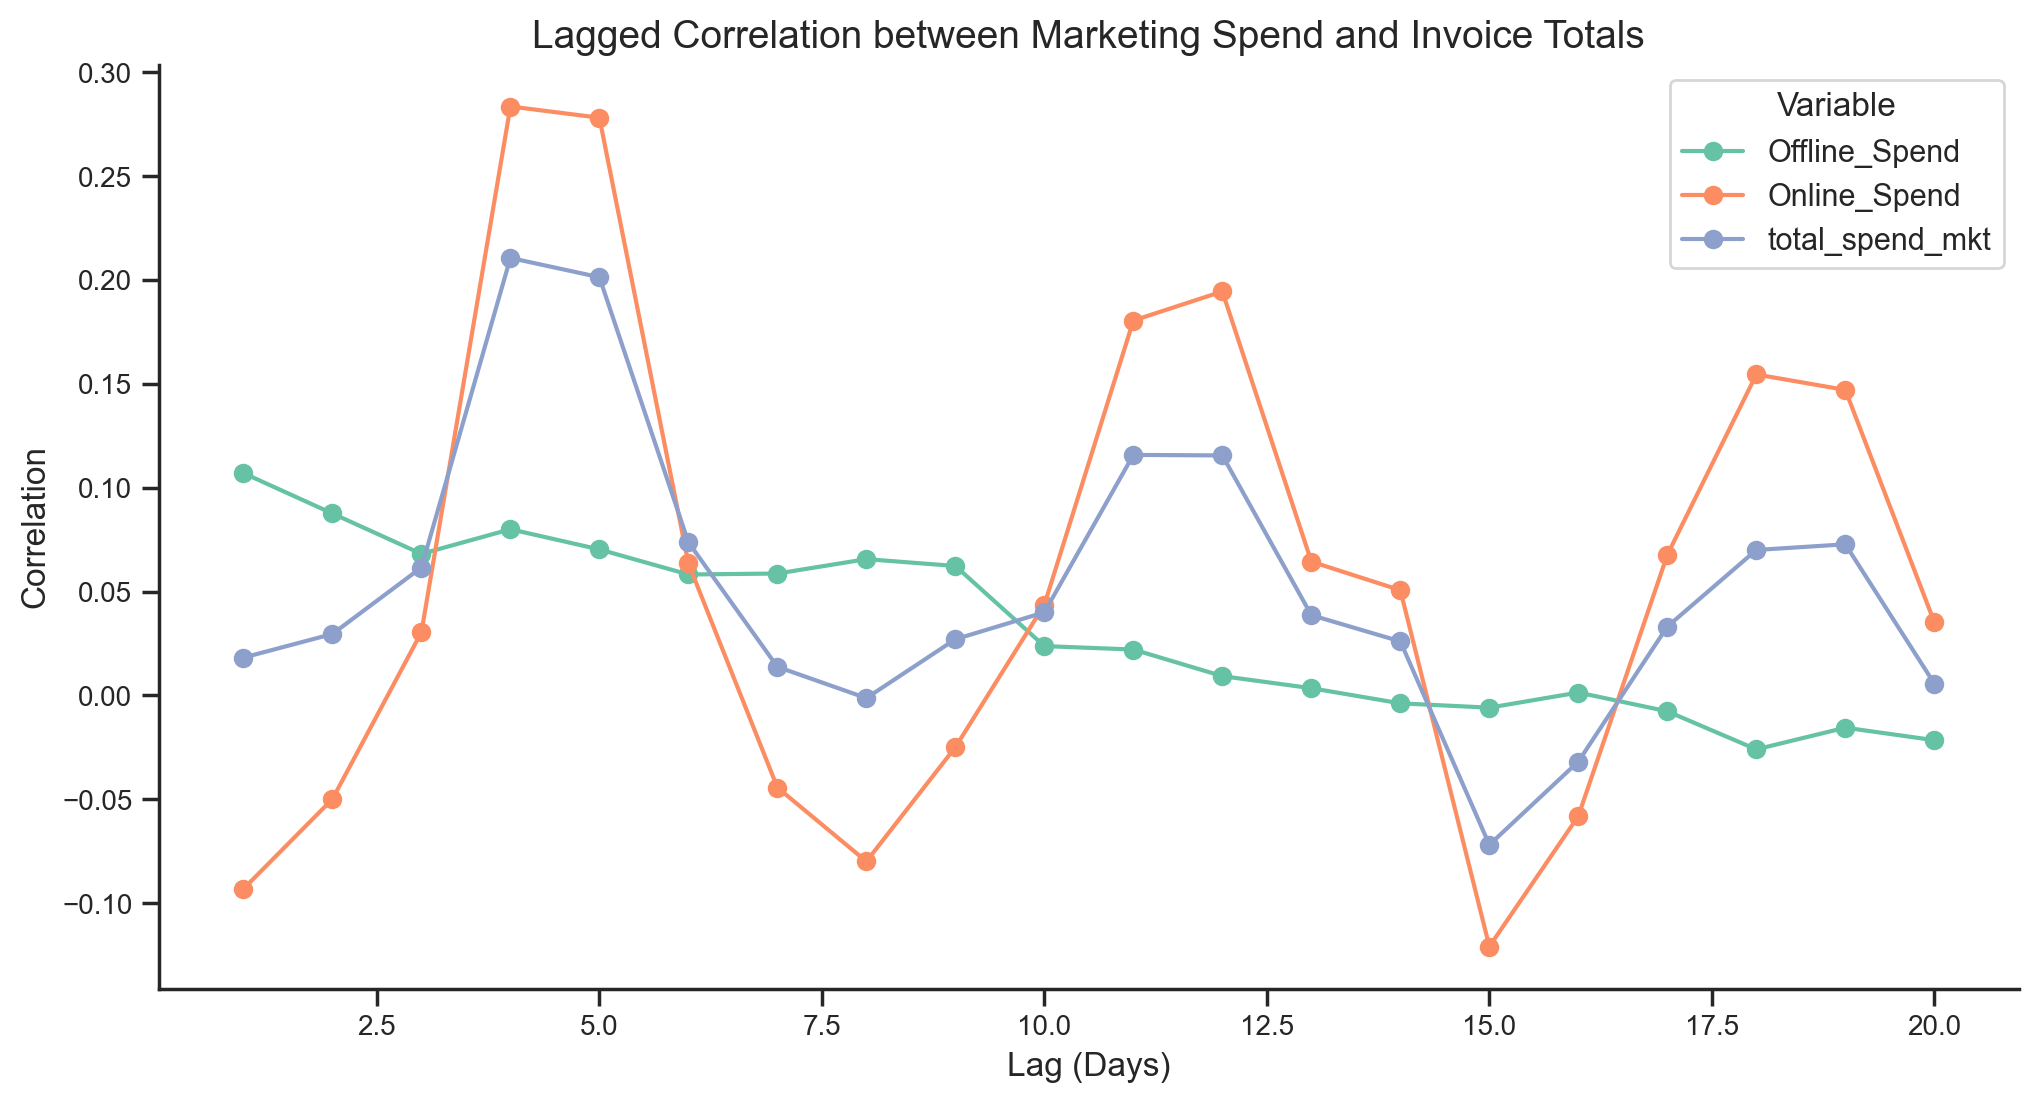

In [330]:
pivoted_correlation_df.plot(marker='o', figsize=(12, 6))
plt.title('Lagged Correlation between Marketing Spend and Invoice Totals')
plt.xlabel('Lag (Days)')
plt.ylabel('Correlation')
plt.show()

- **Online_Spend**: The correlation fluctuates significantly, showing both positive and negative correlations. Peaks are observed around Lag 5 and Lag 15, with the highest positive correlation around Lag 5 (approximately 0.30).
- **Offline_Spend**: The correlation is relatively more stable, with values remaining mostly positive.
- **Lag 0 to 5**: For online spend, suggesting that marketing spend impacts invoice totals within a few days (immediate effects).
- While less impactful, offline marketing provides a consistent contribution to sales and should be maintained as a steady support mechanism.
- These peaks and correlations might be explained by the offers and discounts(?). For example, if I consistently invest in day 0 in specific campaigns for day 4 or day 5, it could influence these patterns. It is a hypotheses that needs to be investigated.

### 2.10. Which product was appeared in the transactions? AND
### 2.11. Which product was purchased mostly based on the quantity?

For the first question, I will count the number of unique transactions in which each product appears. For the second question, I will use the total quantity of each product.

In the EDA document, I included an analysis considering the number of times each item was purchased.

In [332]:
# Product appeared in the transactions

product_appearance = data_tmp.groupby('Product_Description')['Transaction_ID'].nunique().reset_index()
product_appearance.columns = ['Product_Description', 'Transaction_Count']
top_appearance_product = product_appearance.sort_values(by='Transaction_Count', ascending=False).iloc[0]

print(f"Product that appeared the most in transactions: {top_appearance_product['Product_Description']} with {top_appearance_product['Transaction_Count']} appearances.")


Product that appeared the most in transactions: Nest Learning Thermostat 3rd Gen-USA - Stainless Steel with 3511 appearances.


In [333]:
## Which product was purchased mostly based on the quantity?
total_purchased_product = data_tmp[['Product_Description', 'Quantity']]
total_purchased_product = total_purchased_product.groupby('Product_Description')['Quantity'].agg('sum').reset_index()
total_purchased_product = proportion_calc(data_tmp, 'Product_Description').sort_values('prop', ascending=False)
total_purchased_product['cumulative'] = total_purchased_product['prop'].cumsum()

total_purchased_product

,Product_Description,count,prop,cumulative
0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,3511,6.63,6.63
1,Nest Cam Outdoor Security Camera - USA,3328,6.29,12.92
2,Nest Cam Indoor Security Camera - USA,3230,6.10,19.03
3,Google Sunglasses,1523,2.88,21.90
4,Nest Protect Smoke + CO White Battery Alarm-USA,1361,2.57,24.47
...,...,...,...,...
399,Google Tee Red,2,0.00,99.99
400,Google Women's Colorblock Tee White,1,0.00,99.99
401,Compact Journal with Recycled Pages,1,0.00,100.00
402,Android Women's Short Sleeve Tri-blend Badge T...,1,0.00,100.00


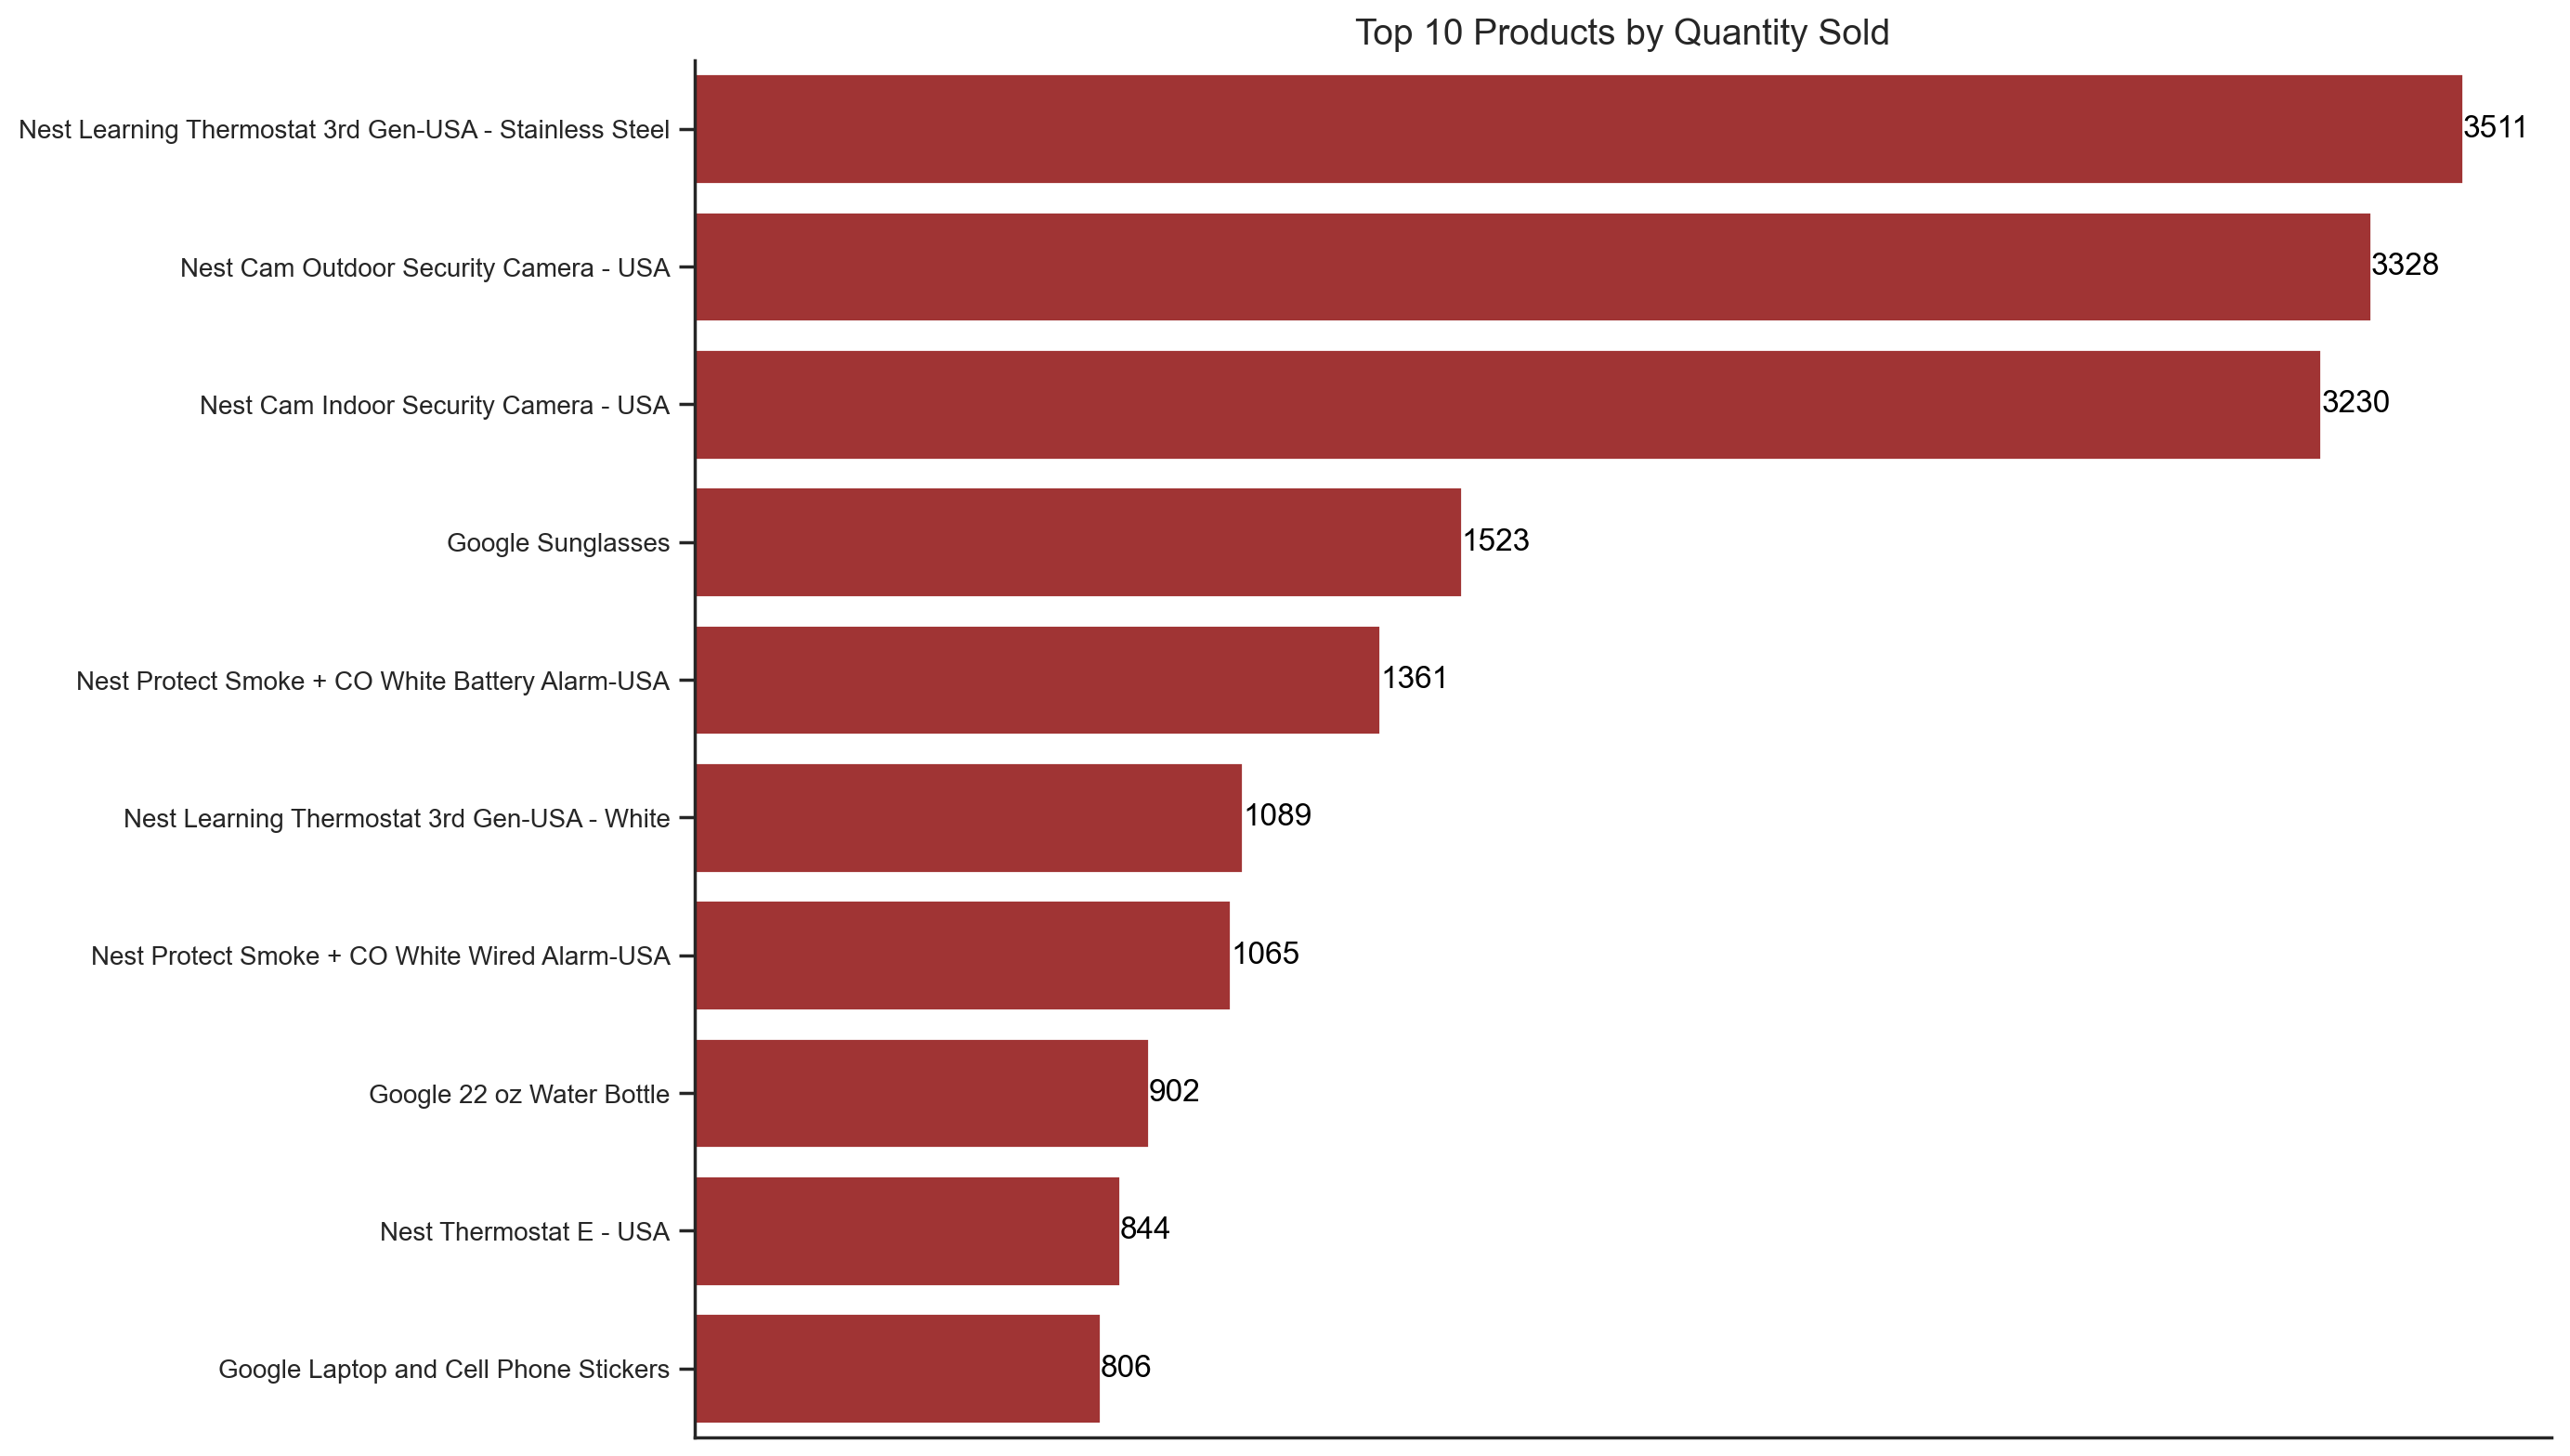

In [334]:
## Top 10

top_10_products = total_purchased_product.nlargest(10, 'count')
# Define the color 
colors = ['firebrick' if value <= 80 else 'grey' for value in amount_products['cumulative']]

# Create the bar plot
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='count', y='Product_Description', data=top_10_products, palette=colors)

# Annotate the bars with the count values
for index, value in enumerate(top_10_products['count']):
    barplot.text(value, index, f'{value}', color='black', ha="left", va="center")

# Set the labels and title
# Set the labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('Top 10 Products by Quantity Sold')

# Remove the x-axis ticks and labels
barplot.set_xticks([])

# Display the plot
plt.tight_layout()
plt.show()


In [335]:
# Saving the main base

data_tmp.to_csv('DATA/base_main.csv', index=False)